# To loan or not to loan - that is the question

This project consists of the development of a data mining case study. It aims to predict whether a loan will be payed back to the bank or not.

## Importing Libraries

In [4]:
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from joblib import parallel_backend

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import EditedNearestNeighbours, CondensedNearestNeighbour, RandomUnderSampler, TomekLinks

## Useful Functions

In [5]:
def csv_df(file, **kwargs):
    return pd.read_csv(file, sep=kwargs.pop('sep', ';'), na_values=kwargs.pop('na_values', None), dtype=kwargs.pop('dtype', None))

def age_when_loan(dataframe):
    date1 = datetime(year=dataframe['owner_year'], month=dataframe['owner_month'], day=1).date()
    date2 = datetime(year=dataframe['loan_year'], month=dataframe['loan_month'], day=1).date()
    return date2.year - date1.year - (date2.month < date1.month)

def amnt_bal_percent(transaction):
    return transaction['amount'] / transaction['balance'] * 100

def make_submission(classifier):
    x_train = final_df.drop(['loan_status'], axis=1)
    y_train = final_df['loan_status']
    x_test = test_final_df.drop(['loan_status'], axis=1)
    x_test = x_test.sort_values(by=['loan_id'])

    classifier.fit(x_train.to_numpy(), y_train.to_numpy())

    y_pred = classifier.predict_proba(x_test.to_numpy())

    print(x_test['loan_id'])

    df = pd.DataFrame(y_pred, columns=['-1', '1'])
    print(df)

    fullDF = pd.read_csv('../data/random_submission.csv')
    fullDF = fullDF.sort_values(by='Id')
    
    fullDF = fullDF.join(df)
    print(fullDF)
    
    fullDF = fullDF.drop(['Predicted', '1'], axis=1).rename(columns={'-1': 'Predicted'})

    print(fullDF.head())

    fullDF.to_csv('../data/random_submission.csv', index=False)

## Loading Data

In [6]:
account_df = csv_df('../data/account.csv')
client_df = csv_df('../data/client.csv')
disp_df = csv_df('../data/disp.csv')
transaction_df = csv_df('../data/trans_train.csv', dtype={'bank': str})
transaction_test_df = csv_df('../data/trans_test.csv')
loan_df = csv_df('../data/loan_train.csv')
loan_test_df = csv_df('../data/loan_test.csv')
card_df = csv_df('../data/card_train.csv')
card_test_df = csv_df('../data/card_test.csv')
district_df = csv_df('../data/district.csv')

## Domain Description

A Czech bank wants to improve their services using a datamining approach. The bank provides data about their clients, the accounts (transactions within several months), the loans already granted, the credit cards issued, dating from 1993 to 1998. This data is provided as a set of *.csv* files.

In [4]:
print('Accounts:', account_df['account_id'].nunique())
print('Clients:', client_df['client_id'].nunique())
print('Districts:', district_df['code '].nunique())
print('Transactions:', transaction_df['trans_id'].nunique() + transaction_test_df['trans_id'].nunique())
print('Loans:', loan_df['loan_id'].nunique() + loan_test_df['loan_id'].nunique())

Accounts: 4500
Clients: 5369
Districts: 77
Transactions: 426885
Loans: 682


## Exploratory Data Analysis I

Finished loans: 85.98%
Ongoing loans: 14.02%
Correlation between amount and duration * payments:  1.0
Districts with at least 100 clients:
1     663
74    180
70    169
54    155
64    109
72    104


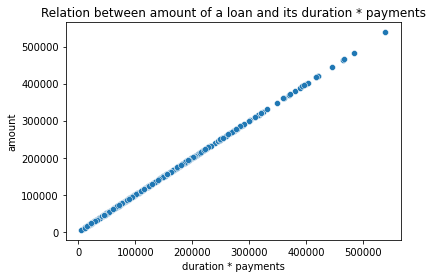

Maximum number of loans on one account: 1


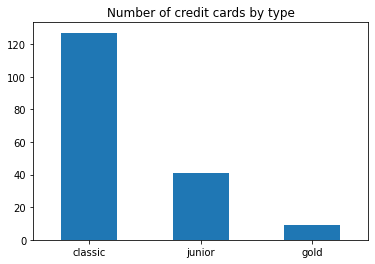

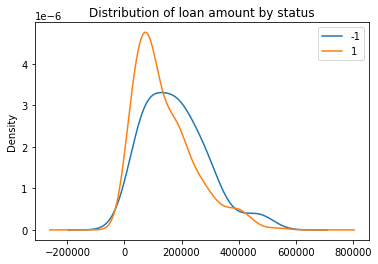

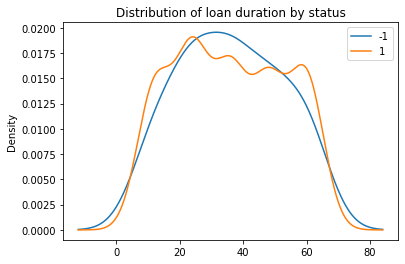

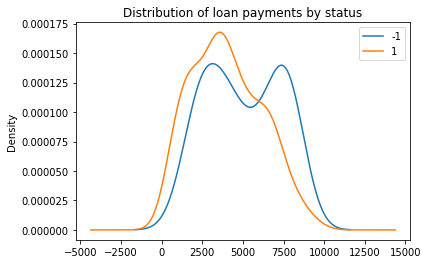

Mean percentage of transaction amount in balance: 14.22%


In [5]:
# Most loans have been payed, so 'status' is unbalanced
a, b = loan_df['status'].value_counts()

print('Finished loans: {}%'.format(round(a / (a + b) * 100, 2)))
print('Ongoing loans: {}%'.format(round(b / (a + b) * 100, 2)))

# amount = duration * payments
print('Correlation between amount and duration * payments: ', loan_df['amount'].corr(loan_df['duration'].multiply(loan_df['payments'])))

# Of all the 77 districts, only 6 have at least 100 clients
print('Districts with at least 100 clients:\n{}'.format(
    client_df.groupby('district_id').filter(lambda x: len(x) >= 100)
    ['district_id'].value_counts().to_string()))

# Interest is not visible in the dataset
sb.scatterplot(x=loan_df['duration'].multiply(loan_df['payments']), y=loan_df['amount'], legend='full')
plt.xlabel('duration * payments')
plt.title('Relation between amount of a loan and its duration * payments')
plt.show()

# There's no account with more than one loan
print('Maximum number of loans on one account:', loan_df['account_id'].value_counts().max())

# Most credit cards are classic type
card_df['type'].value_counts().plot(kind='bar', rot=0)
plt.title('Number of credit cards by type')
plt.show()

# Distribution of loan characteristics according to status
loan_df.groupby('status')['amount'].plot(kind='density', legend=True)
plt.title('Distribution of loan amount by status')
plt.show()

loan_df.groupby('status')['duration'].plot(kind='density', legend=True)
plt.title('Distribution of loan duration by status')
plt.show()

loan_df.groupby('status')['payments'].plot(kind='density', legend=True)
plt.title('Distribution of loan payments by status')
plt.show()

# Mean percentage of transaction amount in balance
print('Mean percentage of transaction amount in balance: {}%'.format(
    round(transaction_df.apply(amnt_bal_percent, axis=1).mean(), 2)))

## Data Pre-processing

In [7]:
def preProcessClient(client_df):
    df = client_df.copy()
    
    # Splitting birth_number
    df['year'] = 1900 + (df['birth_number'] // 10000) # get first 2 digits
    df['day'] = df['birth_number'] % 100 # get last 2 digits
    df['mix'] = (df['birth_number'] % 10000) // 100 # get middle digits
    
    # Adding gender column
    df['gender'] = np.where(df['mix'] >= 50, 'F', 'M')
    gender_categ = pd.get_dummies(df['gender'])
    df = pd.concat((gender_categ, df), axis=1)
    df = df.drop(['gender'],axis=1)
    df = df.drop(['F'],axis=1)
    df = df.rename(columns={'M': 'gender'})
    
    # "Fixing" month, because we already have gender
    df['month'] = np.where(df['mix'] >= 50, df['mix'] - 50, df['mix'])
    
    # Removing unnecessary columns
    df = df.drop(['birth_number', 'mix'], axis=1)
    
    return df 

def preProcessDisp(disp_df):
    df = disp_df.copy()
    
    df = df.rename(columns={'type': 'disp_type'})
    
    return df

def preProcessCard(card_df):
    df = card_df.copy()
    
    df['issued'] = pd.to_datetime(df['issued'], format='%y%m%d')
    df['month'] = df['issued'].dt.month
    df['year'] = df['issued'].dt.year
    df = df.drop(['card_id'], axis=1)
    df = df.rename(columns={'type': 'card_type'})    

    return df

def preProcessDistrict(district_df):
    df = district_df.copy()
    
    # '?' Values to average: 'no. of commited crimes \'95 '
    crimes_NOTNULL = df['no. of commited crimes \'95 '] != '?'
    crimes_NULL = df['no. of commited crimes \'95 '] == '?'
    crimes_average = pd.to_numeric(df[crimes_NOTNULL]['no. of commited crimes \'95 ']).astype(float).median()
    df.loc[crimes_NULL, 'no. of commited crimes \'95 '] = crimes_average
    
    # '?' Values to average: 'unemploymant rate \'95 '
    unemploymant_NOTNULL = df['unemploymant rate \'95 '] != '?'
    unemploymant_NULL = df['unemploymant rate \'95 '] == '?'
    unemploymant_average = pd.to_numeric(df[unemploymant_NOTNULL]['unemploymant rate \'95 ']).astype(float).median()
    df.loc[unemploymant_NULL, 'unemploymant rate \'95 '] = unemploymant_average
    
    # Int -> Float, Obj -> Numeric
    df['unemploymant rate \'95 '] = df['unemploymant rate \'95 '].astype(float)
    df['no. of commited crimes \'95 '] = pd.to_numeric(df['no. of commited crimes \'95 '])
    df['unemploymant rate \'96 '] = df['unemploymant rate \'96 '].astype(float)
    df['no. of commited crimes \'96 '] = pd.to_numeric(df['no. of commited crimes \'96 '])
    df['no. of enterpreneurs per 1000 inhabitants '] = pd.to_numeric(df['no. of enterpreneurs per 1000 inhabitants '])
    df['ratio of urban inhabitants '] = df['ratio of urban inhabitants '].astype(float)
    
    # Ratio: 0-1
    df['entrepeneurs ratio'] = df['no. of enterpreneurs per 1000 inhabitants '] / 1000
    df['ratio of urban inhabitants '] = df['ratio of urban inhabitants '] / 100
    
    # 95-96 Increase on Crimes and Unemploymant
    df['crimes_increase'] = (df['no. of commited crimes \'96 '] - df['no. of commited crimes \'95 ']) / df['no. of inhabitants']
    df['unemploymant_increase'] = df['unemploymant rate \'96 '] - df['unemploymant rate \'95 ']

    # Removing unnecessary columns
    df = df.drop(['no. of enterpreneurs per 1000 inhabitants ', 
                 'unemploymant rate \'96 ', 'no. of commited crimes \'96 ',
                  'unemploymant rate \'95 ', 'no. of commited crimes \'95 ', 'name ', 'region'], axis=1)        
    
    df = df.rename(columns={'code ': 'district_id'})

    return df

def preProcessAccount(account_df):
    df = account_df.copy()
    
    # Splitting account creation date
    df['year'] = 1900 + (df['date'] // 10000) # get first 2 digits
    df['day'] = df['date'] % 100 # get last 2 digits
    df['month'] = (df['date'] % 10000) // 100 # get middle digits
    
    # Removing unnecessary columns
    df = df.drop(['date', 'day', 'frequency', 'district_id'], axis=1)
    
    return df
    
def preProcessLoan(loan_df):
    df = loan_df.copy()
    
    # Splitting loan grant date
    df['year'] = 1900 + (df['date'] // 10000) # get first 2 digits
    df['day'] = df['date'] % 100 # get last 2 digits
    df['month'] = (df['date'] % 10000) // 100 # get middle digits
    
    # Removing unnecessary columns
    df = df.drop(['date'], axis=1)
    
    return df
    
def preProcessTransaction(transaction_df):
    df = transaction_df.copy()
    
    # Splitting loan grant date
    df['year'] = 1900 + (df['date'] // 10000) # get first 2 digits
    df['day'] = df['date'] % 100 # get last 2 digits
    df['month'] = (df['date'] % 10000) // 100 # get middle digits
    
    # Replacing values in type column
    df['type'].replace({'credit': 1, 'withdrawal': -1, 'withdrawal in cash': -1}, inplace=True)
    
    # Removing unnecessary columns
    df = df.drop(['date', 'bank', 'account', 'operation', 'k_symbol'], axis=1)
    
    return df

In [8]:
preProcessedClient_df = preProcessClient(client_df)
preProcessedDisp_df = preProcessDisp(disp_df)
preProcessedCard_df = preProcessCard(card_df)
preProcessedDistrict_df = preProcessDistrict(district_df)
preProcessedAccount_df = preProcessAccount(account_df)
preProcessedLoan_df = preProcessLoan(loan_df)
preProcessedTransaction_df = preProcessTransaction(transaction_df)

## Exploratory Data Analysis II

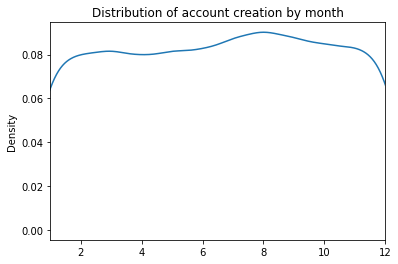

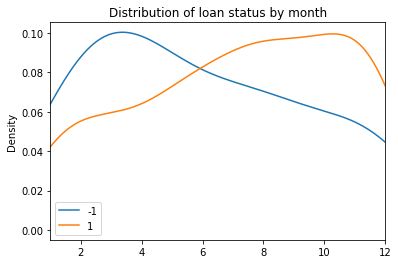

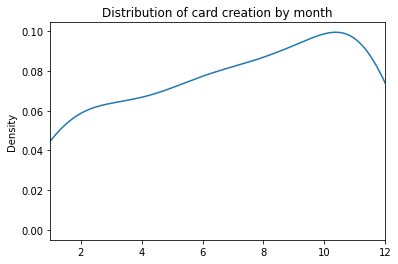

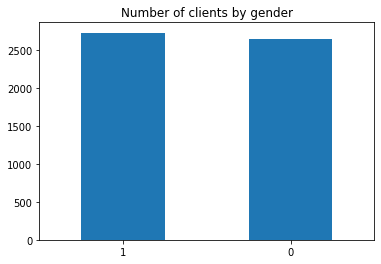

In [8]:
# Distribution of account creation by month
preProcessedAccount_df['month'].plot(kind='density', xlim=(1, 12))
plt.title('Distribution of account creation by month')
plt.show()

# Distribution of loan status by month
preProcessedLoan_df.groupby('status')['month'].plot(kind='density', legend=True, xlim=(1, 12))
plt.title('Distribution of loan status by month')
plt.show()

# Distribution of card creation by month
preProcessedCard_df['issued'].dt.month.plot(kind='density', xlim=(1, 12))
plt.title('Distribution of card creation by month')
plt.show()

# Client gender is almost evenly distributed between male and female
preProcessedClient_df['gender'].value_counts().plot(kind='bar', rot=0)
plt.title('Number of clients by gender')
plt.show()

## Merging Data

In [9]:
# Merging Disp, Client, Card and District
def processRightSide(client, disp, card, district):
    client_df = client.copy()
    disp_df = disp.copy()
    card_df = card.copy()
    card_df = card_df.drop(['issued'], axis=1)
    district_df = district.copy()

    # Clients and Districts don't mix with anything else, so let's merge them
    client_district_df = client_df.merge(district_df, on='district_id', how='left')

    # Merging Disp and Card so we can eliminate disp_id when group by account
    disp_card_df = disp_df.merge(card_df, on='disp_id', how='left')
    disp_card_df = disp_card_df.drop(['disp_id'], axis=1)

    rightSide = disp_card_df.pivot(index='account_id', columns=['disp_type']).droplevel([0], axis=1).set_axis(['disponent_id', 'owner_id', 'disponent_card_type', 'owner_card_type', 'disponent_issued_card_month', 'owner_issued_card_month', 'disponent_issued_card_year', 'owner_issued_card_year'], axis=1).reset_index()

    rightSide = rightSide.merge(client_district_df, left_on='owner_id', right_on='client_id', how='left')
    rightSide = rightSide.merge(client_district_df, left_on='disponent_id', right_on='client_id', how='left', suffixes=('', '_disp'))

    rightSide = rightSide.drop(['client_id', 'client_id_disp', 'district_id', 'district_id_disp', 'disponent_card_type', 'disponent_issued_card_month', 'disponent_issued_card_year'], axis=1)
    rightSide = rightSide.drop(['owner_issued_card_month', 'owner_issued_card_year'], axis=1)
    
    rightSide = rightSide.rename(columns={'gender': 'owner_gender', 'year': 'owner_year', 'day': 'owner_day', 'month': 'owner_month', 'no. of inhabitants': 'owner_num_inhabitants',
        'no. of municipalities with inhabitants < 499 ': 'owner_num_municipalities_less_499',
        'no. of municipalities with inhabitants 500-1999': 'owner_num_municipalities_between_500_1999',
        'no. of municipalities with inhabitants 2000-9999 ': 'owner_num_municipalities_between_2000_9999',
        'no. of municipalities with inhabitants >10000 ': 'owner_num_municipalities_more_10000',
        'no. of cities ': 'owner_num_cities', 'ratio of urban inhabitants ': 'owner_inhabitants_ratio',
        'average salary ': 'owner_average_salary', 'entrepeneurs ratio': 'owner_entrepeneurs_ratio',
        'crimes_increase': 'owner_crimes_increase', 'unemploymant_increase': 'owner_unemploymant_increase'})
    rightSide = rightSide.rename(columns={'gender_disp': 'disponent_gender', 'year_disp': 'disponent_year', 'day_disp': 'disponent_day', 'month_disp': 'disponent_month', 'no. of inhabitants_disp': 'disponent_num_inhabitants',
        'no. of municipalities with inhabitants < 499 _disp': 'disponent_num_municipalities_less_499',
        'no. of municipalities with inhabitants 500-1999_disp': 'disponent_num_municipalities_between_500_1999',
        'no. of municipalities with inhabitants 2000-9999 _disp': 'disponent_num_municipalities_between_2000_9999',
        'no. of municipalities with inhabitants >10000 _disp': 'disponent_num_municipalities_more_10000',
        'no. of cities _disp': 'disponent_num_cities', 'ratio of urban inhabitants _disp': 'disponent_inhabitants_ratio',
        'average salary _disp': 'disponent_average_salary', 'entrepeneurs ratio_disp': 'disponent_entrepeneurs_ratio',
        'crimes_increase_disp': 'disponent_crimes_increase', 'unemploymant_increase_disp': 'disponent_unemploymant_increase'})
    
    rightSide = pd.get_dummies(rightSide)
    
    rightSide.drop(['disponent_gender', 'disponent_year', 'disponent_month',
                    'disponent_num_inhabitants', 'disponent_num_municipalities_less_499',
                    'disponent_num_municipalities_between_500_1999','disponent_num_municipalities_between_2000_9999',
                    'disponent_num_municipalities_more_10000','disponent_num_cities','disponent_inhabitants_ratio',
                    'disponent_average_salary','disponent_entrepeneurs_ratio','disponent_crimes_increase', 'disponent_unemploymant_increase'], axis=1)
    
    return rightSide

rightSide = processRightSide(preProcessedClient_df, preProcessedDisp_df, preProcessedCard_df, preProcessedDistrict_df)
display(rightSide)
print(rightSide.info())

account_id  disponent_id  owner_id  owner_gender  owner_year  owner_day  \
0              1           NaN       1.0             0        1970         13   
1              2           3.0       2.0             1        1945          4   
2              3           5.0       4.0             1        1956          1   
3              4           NaN       6.0             1        1919         22   
4              5           NaN       7.0             1        1929         25   
...          ...           ...       ...           ...         ...        ...   
4495       11333           NaN   13931.0             1        1942          1   
4496       11349       13956.0   13955.0             0        1945         30   
4497       11359           NaN   13968.0             1        1968         13   
4498       11362           NaN   13971.0             0        1962         19   
4499       11382           NaN   13998.0             0        1953         12   

      owner_month  owner_num_inhabitants  owner_num_municipalities_less_499  \
0              12                  70699                                 60   
1               2                1204953                                  0   
2              12                  95616                                 65   
3               9                 107870                                 84   
4               1                  58796                                 22   
...           ...                    ...                                ...   
4495            1                 112065                                 95   
4496           10                1204953                                  0   
4497            4                 117897                                139   
4498           10                 106054                                 38   
4499            8                 323870                                  0   

      owner_num_municipalities_between_500_1999  ...  \
0                                            13  ...   
1                                             0  ...   
2                                            30  ...   
3                                            29  ...   
4                                            16  ...   
...                                         ...  ...   
4495                                         19  ...   
4496                                          0  ...   
4497                                         28  ...   
4498                                         25  ...   
4499                                          0  ...   

      disponent_num_municipalities_more_10000  disponent_num_cities  \
0                                         NaN                   NaN   
1                                         1.0                   1.0   
2                                         1.0                   6.0   
3                                         NaN                   NaN   
4                                         NaN                   NaN   
...                                       ...                   ...   
4495                                      NaN                   NaN   
4496                                      1.0                   1.0   
4497                                      NaN                   NaN   
4498                                      NaN                   NaN   
4499                                      NaN                   NaN   

      disponent_inhabitants_ratio  disponent_average_salary  \
0                             NaN                       NaN   
1                           1.000                   12541.0   
2                           0.514                    9307.0   
3                             NaN                       NaN   
4                             NaN                       NaN   
...                           ...                       ...   
4495                          NaN                       NaN   
4496                        1.000                   12

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 0 to 4499
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   account_id                                      4500 non-null   int64  
 1   disponent_id                                    869 non-null    float64
 2   owner_id                                        4500 non-null   float64
 3   owner_gender                                    4500 non-null   uint8  
 4   owner_year                                      4500 non-null   int64  
 5   owner_day                                       4500 non-null   int64  
 6   owner_month                                     4500 non-null   int64  
 7   owner_num_inhabitants                           4500 non-null   int64  
 8   owner_num_municipalities_less_499               4500 non-null   int64  
 9   owner_num_municipalities_between_500_1999

In [10]:
# Merging Account, Loan, Transaction
def processTransaction(pPTransaction_df):
    df = pPTransaction_df.copy()
    df = df.drop(['trans_id'], axis=1)

    # Get several GroupBy Objects
    gb = df.groupby(['account_id'])
    gb_type = df.groupby(['account_id', 'type'])
    gb_year = df.groupby(['account_id', 'year'])
    gb_year_type = df.groupby(['account_id', 'year', 'type'])
    
    # Get statistics for balance after each transaction
    balance_all = gb.agg({'balance': ['mean', 'min', 'max']}).droplevel(1, axis=1).set_axis(['balance_mean', 'balance_min', 'balance_max'], axis=1)
    
    # Get statistics for number of transactions of each type
    no_of_type_transactions = gb_type.size().to_frame().reset_index().pivot(index='account_id', columns='type').droplevel(['type'], axis=1).set_axis(['debits', 'credits'], axis=1)
    
    # Get statistics for transaction amount and balance after transaction for each type
    amount_balance_type = gb_type.agg({'amount': ['sum', 'mean', 'min', 'max'], 'balance': ['mean', 'min', 'max']}).reset_index().pivot(index='account_id', columns='type').droplevel([0, 'type'], axis=1).set_axis(['amount_sum_debit', 'amount_sum_credit', 'amount_mean_debit', 'amount_mean_credit', 'amount_min_debit', 'amount_min_credit', 'amount_max_debit', 'amount_max_credit', 'balance_mean_debit', 'balance_mean_credit', 'balance_min_debit', 'balance_min_credit', 'balance_max_debit', 'balance_max_credit'], axis=1)
    
    # Get statistics for number of transactions of each year
    no_of_year_transactions = gb_year.size().to_frame().reset_index().pivot(index='account_id', columns='year').droplevel(['year'], axis=1).set_axis(['no. of transactions 1993', 'no. of transactions 1994', 'no. of transactions 1995', 'no. of transactions 1996'], axis=1).fillna(0)
    
    # Get statistics for balance after transaction for each year
    balance_all_year = gb_year.agg({'balance': ['mean', 'min', 'max']}).reset_index().pivot(index='account_id', columns='year').droplevel([0, 1], axis=1).set_axis(['balance_mean_1993', 'balance_mean_1994', 'balance_mean_1995', 'balance_mean_1996', 'balance_min_1993', 'balance_min_1994', 'balance_min_1995', 'balance_min_1996', 'balance_max_1993', 'balance_max_1994', 'balance_max_1995', 'balance_max_1996'], axis=1)
    
    # Get statistics for number of transactions of each type in each year
    no_of_year_type_transactions = gb_year_type.size().to_frame().reset_index().pivot(index='account_id', columns=['year', 'type']).droplevel([0, 1], axis=1).set_axis(['1995_debits', '1995_credits', '1996_debits', '1996_credits', '1993_debits', '1993_credits', '1994_debits', '1994_credits'], axis=1)
    
    # Get statistics for transaction amount and balance after transaction for each type in each year
    amount_balance_year_type = gb_year_type.agg({'amount': ['sum', 'mean', 'min', 'max'], 'balance': ['mean', 'min', 'max']}).reset_index().pivot(index='account_id', columns=['year', 'type']).droplevel([0, 1], axis=1).set_axis(['amount_sum_1993_debit', 'amount_sum_1993_credit', 'amount_sum_1994_debit', 'amount_sum_1994_credit', 'amount_sum_1995_debit', 'amount_sum_1995_credit', 'amount_sum_1996_debit', 'amount_sum_1993_credit', 'amount_mean_1993_debit', 'amount_mean_1993_credit', 'amount_mean_1994_debit', 'amount_mean_1994_credit', 'amount_mean_1995_debit', 'amount_mean_1995_credit', 'amount_mean_1996_debit', 'amount_mean_1996_credit', 'amount_min_1993_debit', 'amount_min_1993_credit', 'amount_min_1994_debit', 'amount_min_1994_credit', 'amount_min_1995_debit', 'amount_min_1995_credit', 'amount_min_1996_debit', 'amount_min_1996_credit', 'amount_max_1993_debit', 'amount_max_1993_credit', 'amount_max_1994_debit', 'amount_max_1994_credit', 'amount_max_1995_debit', 'amount_max_1995_credit', 'amount_max_1996_debit', 'amount_max_1996_credit', 'balance_mean_1993_debit', 'balance_mean_1993_credit', 'balance_mean_1994_debit', 'balance_mean_1994_credit', 'balance_mean_1995_debit', 'balance_mean_1995_credit', 'balance_mean_1996_debit', 'balance_mean_1996_credit', 'balance_min_1993_debit', 'balance_min_1993_credit', 'balance_min_1994_debit', 'balance_min_1994_credit', 'balance_min_1995_debit', 'balance_min_1995_credit', 'balance_min_1996_debit', 'balance_min_1996_credit', 'balance_max_1993_debit', 'balance_max_1993_credit', 'balance_max_1994_debit', 'balance_max_1994_credit', 'balance_max_1995_debit', 'balance_max_1995_credit', 'balance_max_1996_debit', 'balance_max_1996_credit'], axis=1)
    
    # Get balance from last transaction
    last_balance = df.sort_values(['account_id', 'year', 'month', 'day'], ascending=False).groupby('account_id').first()['balance'].to_frame('last_balance')

    # Get new dataframe with number of transactions for each account
    counts = gb.size().to_frame(name='no. of transactions')
    
    # Join all the data for each account
    counts = counts.join(balance_all).join(last_balance).join(no_of_type_transactions).join(amount_balance_type).join(no_of_year_transactions).join(balance_all_year).join(no_of_year_type_transactions).join(amount_balance_year_type).reset_index().fillna(0)
    
    return counts

    
processedTransaction_df = processTransaction(preProcessedTransaction_df)

def joinAccountTransaction(pPAccount_df, pTransaction_df):
    df = pPAccount_df.rename(columns={'year': 'account_year', 'month': 'account_month'})
    
    df = df.set_index('account_id').join(pTransaction_df.set_index('account_id'))
    
    return df

accountTransaction_df = joinAccountTransaction(preProcessedAccount_df, processedTransaction_df)
display(processedTransaction_df)

account_id  no. of transactions  balance_mean  balance_min  balance_max  \
0              1                  113  17558.700000       1000.0      30414.8   
1              2                   54  32590.624074       1100.0      67529.6   
2              4                   39  23648.623077        800.0      30623.5   
3              6                  124  30313.279839        900.0      40391.5   
4              7                    4  23088.850000        900.0      34875.0   
...          ...                  ...           ...          ...          ...   
3365       11333                  208  36827.658173      -1291.0     137043.2   
3366       11349                   18  59352.833333        200.0     104039.9   
3367       11359                  147  36480.185034       1000.0      81705.8   
3368       11362                  107  30869.781308       1000.0      56055.6   
3369       11382                   99  34805.087879      -1036.7      93550.2   

      last_balance  debits  credits  amount_sum_debit  amount_sum_credit  ...  \
0          12659.9    63.0     50.0           86970.2            99630.1  ...   
1          27840.6    32.0     22.0          200844.6           228685.3  ...   
2          24943.0    22.0     17.0           31977.6            56920.5  ...   
3          33509.2    73.0     51.0          150277.8           183787.0  ...   
4          28305.4     1.0      3.0            6600.0            34905.4  ...   
...            ...     ...      ...               ...                ...  ...   
3365       19790.4   107.0    101.0          885468.1           905244.3  ...   
3366       24704.4     7.0     11.0          207486.0           232190.5  ...   
3367       25682.6   102.0     45.0          627249.8           652932.4  ...   
3368       24199.5    78.0     29.0          231341.4           255541.0  ...   
3369       27005.4    50.0     49.0          516241.0           543246.6  ...   

      balance_min_1996_debit  balance_min_1996_credit  balance_max_1993_debit  \
0                    11127.5                  12674.5                     0.0   
1                        0.0                      0.0                 49180.5   
2                    20509.0                    800.0                     0.0   
3                    20377.3                  23201.2                     0.0   
4                    28275.0                    900.0                     0.0   
...                      ...                      ...                     ...   
3365                  8030.3                  14006.1                     0.0   
3366                     0.0                      0.0                     0.0   
3367                  8615.9                  18102.5                     0.0   
3368                 14067.2                  14888.5                     0.0   
3369                 -1036.7                   -947.9                     0.0   

      balance_max_1993_credit  balance_max_1994_debit  \
0                         0.0                     0.0   
1                     67529.6                     0.0   
2                         0.0                     0.0   
3                         0.0                     0.0   
4                         0.0                     0.0   
...                       ...                     ...   
3365                      0.0                107843.2   
3366                      0.0                     0.0   
3367                      0.0                 54520.9   
3368                      0.0                     0.0   
3369                      0.0                     0.0   

      balance_max_1994_credit  balance_max_1995_debit  \
0                         0.0                 26635.2   
1                         0.0                     0.0   
2                         0.0                     0.0   
3                     20907.0                 36437.5   
4                         0.0                     0.0   
...                       ...                     ...   
336

In [11]:
# Merging merge1 and merge2 (by account_id)
def merge12(merge1, merge2):
    
    merge12_df = merge2.merge(merge1, on='account_id')
    
    return merge12_df.fillna(0)
    
merge12_df = merge12(accountTransaction_df, rightSide)
display(merge12_df)

account_id  disponent_id  owner_id  owner_gender  owner_year  owner_day  \
0              1           0.0       1.0             0        1970         13   
1              2           3.0       2.0             1        1945          4   
2              3           5.0       4.0             1        1956          1   
3              4           0.0       6.0             1        1919         22   
4              5           0.0       7.0             1        1929         25   
...          ...           ...       ...           ...         ...        ...   
4495       11333           0.0   13931.0             1        1942          1   
4496       11349       13956.0   13955.0             0        1945         30   
4497       11359           0.0   13968.0             1        1968         13   
4498       11362           0.0   13971.0             0        1962         19   
4499       11382           0.0   13998.0             0        1953         12   

      owner_month  owner_num_inhabitants  owner_num_municipalities_less_499  \
0              12                  70699                                 60   
1               2                1204953                                  0   
2              12                  95616                                 65   
3               9                 107870                                 84   
4               1                  58796                                 22   
...           ...                    ...                                ...   
4495            1                 112065                                 95   
4496           10                1204953                                  0   
4497            4                 117897                                139   
4498           10                 106054                                 38   
4499            8                 323870                                  0   

      owner_num_municipalities_between_500_1999  ...  balance_min_1996_debit  \
0                                            13  ...                 11127.5   
1                                             0  ...                     0.0   
2                                            30  ...                     0.0   
3                                            29  ...                 20509.0   
4                                            16  ...                     0.0   
...                                         ...  ...                     ...   
4495                                         19  ...                  8030.3   
4496                                          0  ...                     0.0   
4497                                         28  ...                  8615.9   
4498                                         25  ...                 14067.2   
4499                                          0  ...                 -1036.7   

      balance_min_1996_credit  balance_max_1993_debit  \
0                     12674.5                     0.0   
1                         0.0                 49180.5   
2                         0.0                     0.0   
3                       800.0                     0.0   
4                         0.0                     0.0   
...                       ...                     ...   
4495                  14006.1                     0.0   
4496                      0.0                     0.0   
4497                  18102.5                     0.0   
4498                  14888.5                     0.0   
4499                   -947.9                     0.0   

      balance_max_1993_credit  balance_max_1994_debit  \
0                         0.0                     0.0   
1                     67529.6                     0.0   
2                         0.0                     0.0   
3                         0.0                     0.0   
4                         0.0                     0.0   
...                       ...                     ...   
4495                      0.0          

In [12]:
# Final merge: merge12 with loans
def finalMerge(merge12, loans):
    final_df = merge12.merge(loans, on='account_id')
    final_df = final_df.rename(columns={'amount': 'loan_amount', 
        'duration': 'loan_duration', 'payments': 'loan_payments',
        'year': 'loan_year', 'month': 'loan_month',
        'status': 'loan_status', 'day': 'loan_day'})
    final_df = final_df.drop(['owner_id', 'disponent_id', 'account_id'], axis=1)
    
    return final_df

final_df = finalMerge(merge12_df, preProcessedLoan_df)

# Create "months until account reaches 0 if there are no more credits" feature
final_df['months_until_0'] = final_df['last_balance'] / final_df['loan_payments']

# Create "age in days" feature
final_df['age'] = (final_df['loan_year'] * 365 + final_df['loan_month'] * 30 + final_df['loan_day']) - (final_df['owner_year'] * 365 + final_df['owner_month'] * 30 + final_df['owner_day'])

display(final_df)

owner_gender  owner_year  owner_day  owner_month  owner_num_inhabitants  \
0               1        1945          4            2                1204953   
1               0        1939         23            4                 103347   
2               0        1944         13            6                  93931   
3               0        1945          3            7                 128118   
4               1        1939         30           11                 125832   
..            ...         ...        ...          ...                    ...   
323             0        1980         13           11                 107870   
324             1        1973         16            2                  58796   
325             0        1945         30           10                1204953   
326             1        1968         13            4                 117897   
327             0        1962         19           10                 106054   

     owner_num_municipalities_less_499  \
0                                    0   
1                                   87   
2                                   74   
3                                    9   
4                                  151   
..                                 ...   
323                                 84   
324                                 22   
325                                  0   
326                                139   
327                                 38   

     owner_num_municipalities_between_500_1999  \
0                                            0   
1                                           16   
2                                           21   
3                                           16   
4                                           41   
..                                         ...   
323                                         29   
324                                         16   
325                                          0   
326                                         28   
327                                         25   

     owner_num_municipalities_between_2000_9999  \
0                                             0   
1                                             7   
2                                            10   
3                                             6   
4                                             2   
..                                          ...   
323                                           6   
324                                           7   
325                                           0   
326                                           5   
327                                           6   

     owner_num_municipalities_more_10000  owner_num_cities  ...  loan_id  \
0                                      1                 1  ...     4959   
1                                      1                 7  ...     4961   
2                                      1                 8  ...     4973   
3                                      3                 8  ...     4996   
4                                      3                 5  ...     5002   
..                                   ...               ...  ...      ...   
323                                    1                 6  ...     7271   
324                                    1                 5  ...     7284   
325                                    1                 1  ...     7304   
326                                    1                 6  ...     7305   
327                                    2                 6  ...     7308   

     loan_amount  loan_duration  loan_payments  loan_status  loan_year  \
0          80952             24           3373            1       1994   
1          30276             12           2523           -1       1996   
2         165960             24           6915            1       1996   
3          88440             12           7370            1       1996   
4         104808             12           

## Exploratory Data Analysis III

In [13]:
# Correlation between gender and loan status
print(final_df['owner_gender'].corr(final_df['loan_status']))

# Distribution of account owner ages when getting a loan
#final_df.apply(age_when_loan, axis=1).plot(kind='density', xlim=(0, 80))
#plt.title('Distribution of account owner ages when getting a loan')
#plt.show()

0.022487142349834354


In [13]:
preProcessedCardTest_df = preProcessCard(card_test_df)
preProcessedLoanTest_df = preProcessLoan(loan_test_df)
preProcessedTransactionTest_df = preProcessTransaction(transaction_test_df)

In [14]:
test1 = processRightSide(preProcessedClient_df, preProcessedDisp_df, preProcessedCardTest_df, preProcessedDistrict_df)
test2 = processTransaction(preProcessedTransactionTest_df)
test2 = joinAccountTransaction(preProcessedAccount_df, test2)
test3 = merge12(test2, test1)
test_final_df = finalMerge(test3, preProcessedLoanTest_df)

# Create "months until account reaches 0 if there are no more credits" feature
test_final_df['months_until_0'] = test_final_df['last_balance'] / test_final_df['loan_payments']

# Create "age in days" feature
test_final_df['age'] = (test_final_df['loan_year'] * 365 + test_final_df['loan_month'] * 30 + test_final_df['loan_day']) - (test_final_df['owner_year'] * 365 + test_final_df['owner_month'] * 30 + test_final_df['owner_day'])

display(test_final_df)

owner_gender  owner_year  owner_day  owner_month  owner_num_inhabitants  \
0               1        1962          9            2                 228848   
1               1        1952         26            8                  70646   
2               0        1940         30            1                  51428   
3               1        1942         28            1                 323870   
4               1        1967         21            9                 105606   
..            ...         ...        ...          ...                    ...   
349             0        1948         31            7                 133777   
350             1        1972         26            1                  95616   
351             1        1975         20           11                 102609   
352             0        1979         22            2                  94725   
353             0        1952          9            9                 387570   

     owner_num_municipalities_less_499  \
0                                   15   
1                                   94   
2                                   50   
3                                    0   
4                                   77   
..                                 ...   
349                                 24   
350                                 65   
351                                 75   
352                                 38   
353                                  0   

     owner_num_municipalities_between_500_1999  \
0                                           40   
1                                           14   
2                                           11   
3                                            0   
4                                           26   
..                                         ...   
349                                         17   
350                                         30   
351                                         33   
352                                         28   
353                                          0   

     owner_num_municipalities_between_2000_9999  \
0                                            18   
1                                             3   
2                                             3   
3                                             0   
4                                             7   
..                                          ...   
349                                           7   
350                                           4   
351                                           2   
352                                           1   
353                                           0   

     owner_num_municipalities_more_10000  owner_num_cities  ...  loan_id  \
0                                      2                 6  ...     4962   
1                                      1                 4  ...     4967   
2                                      1                 4  ...     4968   
3                                      1                 1  ...     4986   
4                                      2                 7  ...     4988   
..                                   ...               ...  ...      ...   
349                                    3                11  ...     7279   
350                                    1                 6  ...     7286   
351                                    3                 6  ...     7292   
352                                    3                 6  ...     7294   
353                                    1                 1  ...     7295   

     loan_amount  loan_duration  loan_payments  loan_status  loan_year  \
0          30276             12           2523          NaN       1997   
1         318480             60           5308          NaN       1998   
2         110736             48           2307          NaN       1998   
3         102876             12           8573          NaN       1997   
4         265320             36           

## Feature Selection

In [15]:
# Create correlation matrix
corr_matrix = final_df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print(final_df.columns)

# Drop features 
final_df.drop(to_drop, axis=1, inplace=True)
test_final_df.drop(to_drop, axis=1, inplace=True)

import statsmodels.api as sm
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

SL = 0.05
data_modeled, selected_columns = backwardElimination(final_df.drop(['loan_id', 'loan_status'], axis=1).values, final_df['loan_status'].values, SL, final_df.drop(['loan_id','loan_status'], axis=1).columns)
print(selected_columns)
test = pd.DataFrame(data = data_modeled, columns = selected_columns)
test['loan_status'] = final_df['loan_status']
test['loan_id'] = final_df['loan_id']

final_df = test

test = test_final_df[selected_columns]
test['loan_status'] = test_final_df['loan_status']
test['loan_id'] = test_final_df['loan_id']

test_final_df = test

Index(['owner_gender', 'owner_year', 'owner_day', 'owner_month',
       'owner_num_inhabitants', 'owner_num_municipalities_less_499',
       'owner_num_municipalities_between_500_1999',
       'owner_num_municipalities_between_2000_9999',
       'owner_num_municipalities_more_10000', 'owner_num_cities',
       ...
       'loan_id', 'loan_amount', 'loan_duration', 'loan_payments',
       'loan_status', 'loan_year', 'loan_day', 'loan_month', 'months_until_0',
       'age'],
      dtype='object', length=146)
Index(['disponent_inhabitants_ratio', 'owner_card_type_gold',
       'no. of transactions', 'balance_min', 'balance_min_debit',
       'balance_min_credit', 'amount_min_1995_debit', 'amount_min_1996_debit',
       'loan_payments'],
      dtype='object')


C:\Users\DIOGON~1\AppData\Local\Temp/ipykernel_10360/1606055684.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['loan_status'] = test_final_df['loan_status']
C:\Users\DIOGON~1\AppData\Local\Temp/ipykernel_10360/1606055684.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['loan_id'] = test_final_df['loan_id']


## Saving DataFrames as CSV

In [16]:
final_df.to_csv("train.csv")
test_final_df.to_csv("test.csv")

## Model Training

In [17]:
x = final_df.drop(['loan_status'], axis=1)
y = final_df['loan_status']

cross_validation = StratifiedKFold(n_splits=10)

In [18]:
over = [SMOTE(), ADASYN(), RandomOverSampler()]
under = [EditedNearestNeighbours(), CondensedNearestNeighbour(), RandomUnderSampler(), TomekLinks()]

def resamplingGridSearch(classifier, params):
    best = {
        'resampler': [],
        'score': 0,
        'parameters': {}
    }
    
    for o in over:
        for u in under:
            pl = Pipeline([('o', o), ('u', u), ('classification', classifier)])
            
            grid_search = GridSearchCV(pl, params, cv=cross_validation, scoring='roc_auc', n_jobs=-1, verbose=3)

            with parallel_backend('threading', n_jobs=-1):
                grid_search.fit(x.to_numpy(), y.to_numpy())

                print('Resamplers: {} and {}'.format(o, u))
                print('Best score: {}'.format(grid_search.best_score_))
                print('Best parameters: {}'.format(grid_search.best_params_))
            
            if grid_search.best_score_ > best["score"]:
                best.update({'resampler': [o, u], 'score': grid_search.best_score_, 'parameters': grid_search.best_params_})
    
    return best

In [19]:
# Random Forest

rf_classifier = RandomForestClassifier()

rf_parameter_grid = {
    'classification__n_estimators': [100, 500],
    'classification__criterion': ['gini', 'entropy'],
    'classification__min_samples_split': [0.1, 0.3, 0.5],
    'classification__max_features': [None, 'sqrt', 'log2', 0.2, 0.5, 0.8]
}

best_rf = resamplingGridSearch(rf_classifier, rf_parameter_grid)

print(best_rf)

# Fitting 10 folds for each of 72 candidates, totalling 720 fits
# {'resampler': [SMOTE(), RandomUnderSampler()],
# 'score': 0.9173152709359608,
# 'parameters': {'classification__criterion': 'entropy',
#                'classification__max_features': 0.2, 
#                'classification__min_samples_split': 0.5,
#                'classification__n_estimators': 500}}

Fitting 10 folds for each of 72 candidates, totalling 720 fits
[CV 7/10] END classification__criterion=gini, classification__max_features=None, classification__min_samples_split=0.1, classification__n_estimators=100;, score=0.850 total time=   0.8s
[CV 6/10] END classification__criterion=gini, classification__max_features=None, classification__min_samples_split=0.1, classification__n_estimators=100;, score=0.764 total time=   0.9s
[CV 5/10] END classification__criterion=gini, classification__max_features=None, classification__min_samples_split=0.1, classification__n_estimators=100;, score=0.925 total time=   1.0s
[CV 2/10] END classification__criterion=gini, classification__max_features=None, classification__min_samples_split=0.1, classification__n_estimators=100;, score=0.948 total time=   1.0s
[CV 3/10] END classification__criterion=gini, classification__max_features=None, classification__min_samples_split=0.1, classification__n_estimators=100;, score=0.896 total time=   1.0s
[CV 8/1

In [20]:
# SVM

svm_classifier = SVC()

svm_parameter_grid = {
    'classification__kernel': ['poly', 'rbf'],
    'classification__C': [0.1, 1, 10],
    'classification__gamma': [0.1, 1]
}

best_svm = resamplingGridSearch(svm_classifier, svm_parameter_grid)

print(best_svm)

# Fitting 10 folds for each of 12 candidates, totalling 120 fits
# {'resampler': [ADASYN(), EditedNearestNeighbours()], 
#  'score': 0.7657142857142857, 
#  'parameters': {
#       'classification__C': 1,
#       'classification__gamma': 1,
#       'classification__kernel': 'poly'}}

Fitting 10 folds for each of 12 candidates, totalling 120 fits


In [28]:
# Logistic Regression

logreg_classifier = LogisticRegression()

logreg_parameter_grid = {
    'classification__penalty': ['l1', 'l2', None],
    'classification__class_weight':['balanced', None],
    'classification__C': [0.1, 1, 10],
    'classification__solver': ['saga']
}

best_logreg = resamplingGridSearch(logreg_classifier, logreg_parameter_grid)

print(best_logreg)

# Fitting 10 folds for each of 18 candidates, totalling 180 fits
# {'resampler': [RandomOverSampler(), TomekLinks()],
#  'score': 0.8546305418719212,
#  'parameters': {
#       'classification__C': 10,
#       'classification__class_weight': None,
#       'classification__penalty': 'none',
#       'classification__solver': 'saga'}}

Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.836 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.857 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.800 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.707 total time=   0.0s[CV 1/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.845 total time=   0.0s

[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classifi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 9/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.946 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s[CV 8/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s


[CV 6/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 9/10]

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 2/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.993 total time=   0.0s[CV 1/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s[CV 4/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s


[CV 8/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.686 total time=   0.0s[CV 3/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s[CV 10/10] END classification__C=0.1

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni


[CV 2/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 4/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 8/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.686 total time=   0.0s
[CV 7/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=1.000 total time=   0.0s
[CV 3/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 10/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.536 total time=   0.0s
[CV 6/10] END classi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni


[CV 7/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.993 total time=   0.0s
[CV 1/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 2/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 3/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s[CV 8/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.707 total time=   0.0s

[CV 4/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 10/10] END classification__C=1, classific

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 3/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.886 total time=   0.0s
[CV 1/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.836 total time=   0.0s
[CV 4/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.843 total time=   0.0s[CV 2/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.879 total time=   0.0s

[CV 5/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.936 total time=   0.0s
[CV 6/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.814 total time=   0.0s[CV 7/10] END cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 9/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.946 total time=   0.0s
[CV 3/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.871 total time=   0.0s
[CV 2/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.862 total time=   0.0s
[CV 10/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.527 total time=   0.0s
[CV 6/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.814 total time=   0.0s
[CV 4/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.843 total time=   0.0s
[CV 5/10] END classification__C=10, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 6/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.621 total time=   1.1s
[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.900 total time=   1.1s
[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.957 total time=   1.1s[CV 2/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.879 total time=   1.1s

[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.514 total time=   1.1s
[CV 5/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.686 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.650 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.500 total time=   1.1s
[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.693 total time=   1.0s
[CV 2/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.560 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.636 total time=   1.3s
[CV 9/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.295 total time=   1.5s
[CV 5/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.229 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.686 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.814 total time=   1.2s
[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.993 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.491 total time=   1.3s
[CV 10/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.348 total time=   1.4s
[CV 2/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.0s
[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.5s
[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.7s
[CV 5/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.5s
[CV 6/10]

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.5s
[CV 8/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.4s
[CV 3/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.864 total time=   0.6s
[CV 9/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.3s
[CV 10/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   4.3s
[CV 2/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.707 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.784 total time=   6.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.557 total time=   1.1s
[CV 8/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.493 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.743 total time=   1.3s
[CV 6/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.786 total time=   1.3s
[CV 7/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=1.000 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.411 total time=   1.3s
[CV 10/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.607 total time=   1.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.821 total time=   1.1s
[CV 5/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.871 total time=   1.0s
[CV 2/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.664 total time=   1.3s
[CV 4/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.836 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.993 total time=   1.3s
[CV 6/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.707 total time=   1.5s
[CV 9/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.393 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.621 total time=   1.3s
[CV 10/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.652 total time=   1.4s
[CV 4/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.7s
[CV 2/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.3s
[CV 3/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.3s
[CV 7/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.9s
[CV 5/10] END classification__C=0

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.4s
[CV 1/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.784 total time=   4.5s
[CV 8/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.1s
[CV 10/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.5s
[CV 9/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.814 total time=   1.1s
[CV 2/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.845 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.514 total time=   1.4s
[CV 5/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.850 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.607 total time=   1.2s
[CV 8/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.671 total time=   0.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.821 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.420 total time=   1.4s
[CV 10/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.598 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.802 total time=   1.5s
[CV 3/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.700 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.836 total time=   1.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.321 total time=   1.1s
[CV 1/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   7.1s[CV 5/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.943 total time=   1.4s

[CV 1/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.845 total time=   4.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.700 total time=   1.4s
[CV 7/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.993 total time=   1.4s
[CV 10/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.500 total time=   0.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.732 total time=   1.2s
[CV 2/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.1s
[CV 3/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.2s
[CV 7/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.7s
[CV 4/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.2s
[CV 6/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.3s
[CV 5/10] END classifi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.836 total time=   5.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.843 total time=   1.2s
[CV 2/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.784 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.650 total time=   0.8s
[CV 5/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.507 total time=   1.3s
[CV 4/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.493 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.971 total time=   1.2s
[CV 9/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.491 total time=   1.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.614 total time=   1.5s
[CV 4/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.786 total time=   0.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.616 total time=   1.5s
[CV 2/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.767 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.879 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.786 total time=   1.1s
[CV 6/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.743 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.643 total time=   0.5s
[CV 7/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.986 total time=   1.5s[CV 1/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   6.8s



C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.593 total time=   1.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.312 total time=   1.4s
[CV 2/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.793 total time=   6.2s
[CV 3/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.3s
[CV 7/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.6s
[CV 4/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.4s
[CV 5/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.4s
[CV 6/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.3s
[CV 8/10] END classification__C=1, classificat

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.900 total time=   1.5s
[CV 2/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.966 total time=   1.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.664 total time=   0.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.871 total time=   1.2s
[CV 1/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.802 total time=   7.2s
[CV 5/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.586 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=1.000 total time=   1.0s[CV 9/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.607 total time=   0.8s



C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.650 total time=   1.3s
[CV 10/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.411 total time=   1.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.767 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.793 total time=   1.0s
[CV 6/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.743 total time=   0.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.786 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.964 total time=   1.3s
[CV 1/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   7.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.607 total time=   0.8s
[CV 7/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.864 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.536 total time=   0.8s
[CV 1/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.802 total time=   5.6s
[CV 8/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.743 total time=   1.3s
[CV 5/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.6s
[CV 2/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.2s
[CV 3/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.2s
[CV 4/10] END c

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.526 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.893 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 1/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.802 total time=   6.3s
[CV 7/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.993 total time=   0.8s
[CV 5/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.407 total time=   1.3s[CV 6/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.693 total time=   1.2s

[CV 4/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.664 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.614 total time=   1.3s
[CV 10/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.670 total time=   0.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.420 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.655 total time=   1.3s
[CV 3/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.764 total time=   1.4s
[CV 1/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   5.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.800 total time=   1.1s
[CV 4/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.771 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.614 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.329 total time=   1.5s
[CV 8/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.621 total time=   1.4s
[CV 9/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.312 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.661 total time=   1.5s
[CV 1/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.767 total time=   6.1s
[CV 2/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.4s
[CV 3/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.3s
[CV 5/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.5s
[CV 4/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.5s
[CV 6/10] END classification__C=10, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Diogo Nunes\AppData\Roaming\Python\Python3

Resamplers: SMOTE() and CondensedNearestNeighbour()
Best score: 0.7604679802955665
Best parameters: {'classification__C': 10, 'classification__class_weight': 'balanced', 'classification__penalty': 'l2', 'classification__solver': 'saga'}
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.857 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.845 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.821 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.974 total time=   0.0s[CV 6/10] END classification__C=0.1, clas

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 8/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s[CV 9/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.938 total time=   0.0s

[CV 9/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.879 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.857 total time=   0.0s
[CV 4/10] END cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni


[CV 8/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.679 total time=   0.0s
[CV 2/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.983 total time=   0.0s
[CV 7/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.993 total time=   0.0s
[CV 6/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.807 total time=   0.0s
[CV 3/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.850 total time=   0.0s
[CV 5/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.886 total time=   0.0s
[CV 10/10] END classification__C=1, classific

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 5/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.886 total time=   0.0s
[CV 7/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.993 total time=   0.0s[CV 4/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.836 total time=   0.0s

[CV 8/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.679 total time=   0.0s
[CV 1/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.862 total time=   0.0s
[CV 1/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.862 total time=   0.0s
[CV 6/10] END cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 8/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.707 total time=   0.0s

[CV 10/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.580 total time=   0.0s
[CV 4/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.829 total time=   0.0s[CV 6/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.821 total time=   0.0s

[CV 9/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.938 total time=   0.0s[CV 5/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.879 total time=   0.0s

[CV 1/10] END classification__C=10, cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=1.000 total time=   0.0s[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.814 total time=   0.0s[CV 8/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.700 total time=   0.0s


[CV 6/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.800 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.864 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.966 total time=   0.0s[CV 1/10] E

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 2/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.966 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.879 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.821 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.879 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.857 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.807 total time=   0.0s
[CV 7/10] END classification__C=0.

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 2/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.983 total time=   0.0s
[CV 1/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.879 total time=   0.0s[CV 3/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.864 total time=   0.0s

[CV 6/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.807 total time=   0.0s
[CV 7/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.993 total time=   0.0s
[CV 5/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.879 total time=   0.0s
[CV 4/10] END classifi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 1/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.862 total time=   0.0s
[CV 4/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.829 total time=   0.0s
[CV 2/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.983 total time=   0.0s
[CV 7/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.993 total time=   0.0s
[CV 8/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.686 total time=   0.0s
[CV 3/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.864 total time=   0.0s[CV 5/10] END classification__C=1, classificati

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 1/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.862 total time=   0.0s[CV 3/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.857 total time=   0.0s

[CV 2/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.983 total time=   0.0s
[CV 4/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.850 total time=   0.0s
[CV 5/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.886 total time=   0.0s
[CV 6/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.807 total time=   0.0s
[CV 7/10] END cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 2/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.966 total time=   0.0s
[CV 3/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.857 total time=   0.0s
[CV 4/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.821 total time=   0.0s
[CV 5/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.886 total time=   0.0s
[CV 6/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.807 total time=   0.0s
[CV 7/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.993 total time=   0.0s
[CV 8/10] END classification__C=10, clas

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

Resamplers: SMOTE() and TomekLinks()
Best score: 0.8488854679802957
Best parameters: {'classification__C': 10, 'classification__class_weight': 'balanced', 'classification__penalty': 'l2', 'classification__solver': 'saga'}
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 2/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.853 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.836 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.836 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=1.000 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni


[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=1.000 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.714 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.938 total time=   0.0s[CV 10/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.589 total time=   0.0s

[CV 4/10

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 4/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.857 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.807 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.871 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.893 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.993 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 1/10] END classification__C=0.

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 8/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.714 total time=   0.0s
[CV 10/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.580 total time=   0.0s
[CV 2/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.853 total time=   0.0s
[CV 4/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.836 total time=   0.0s
[CV 1/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.845 total time=   0.0s
[CV 9/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.938 total time=   0.0s
[CV 5/10] END classif

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 3/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.850 total time=   0.0s
[CV 8/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.707 total time=   0.0s
[CV 5/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.893 total time=   0.0s
[CV 7/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=1.000 total time=   0.0s
[CV 9/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.938 total time=   0.0s
[CV 6/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.807 total time=   0.0s
[CV 10/10] END classification__C=1, classifica

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 10/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 2/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.853 total time=   0.0s
[CV 4/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.850 total time=   0.0s
[CV 1/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.845 total time=   0.0s
[CV 6/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.786 total time=   0.0s
[CV 3/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.864 total time=   0.0s[CV 5/10] END classif

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 9/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.929 total time=   0.0s
[CV 6/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 4/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 8/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 5/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s[CV 7/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s

[CV 9/10] END cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 2/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 7/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=1.000 total time=   0.0s[CV 8/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.700 total time=   0.0s

[CV 3/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 5/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 10/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.554 total time=   0.0s
[CV 7/10] END classification__C=10, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.686 total time=   1.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.807 total time=   5.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.879 total time=   5.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.957 total time=   6.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.802 total time=   7.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.793 total time=   8.0s
[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.843 total time=   8.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.986 total time=   8.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.964 total time=   8.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.545 total time=   6.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.650 total time=   0.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.810 total time=   7.9s
[CV 6/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.814 total time=   5.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.957 total time=   8.3s
[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.757 total time=   6.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.850 total time=   7.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.893 total time=   8.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.946 total time=   5.9s
[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.986 total time=   8.6s
[CV 1/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   6.1s
[CV 8/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.4s
[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   6.0s
[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   7.3s
[CV 10/10]

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   4.3s
[CV 2/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   9.9s
[CV 10/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   3.3s
[CV 5/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   8.9s
[CV 9/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   7.0s
[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   9.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.948 total time=   8.2s
[CV 8/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.643 total time=   1.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.776 total time=   8.7s
[CV 5/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.893 total time=   5.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.864 total time=   8.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.793 total time=   7.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.836 total time=   8.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.979 total time=   9.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.571 total time=   7.1s
[CV 9/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.955 total time=   7.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.802 total time=   7.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.948 total time=   7.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.864 total time=   8.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.650 total time=   2.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.793 total time=   8.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.571 total time=   4.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.836 total time=   6.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.871 total time=   9.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.938 total time=   7.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.979 total time=   8.2s
[CV 1/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   8.3s[CV 8/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.9s

[CV 2/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   8.1s
[CV 3/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   9.2s
[CV 6/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   6.9s
[CV 10/10] END classification__C=0

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.845 total time=   7.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.693 total time=   2.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.771 total time=   5.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.986 total time=   6.0s
[CV 3/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.850 total time=   8.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.893 total time=   7.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.807 total time=   7.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.974 total time=  10.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.955 total time=   7.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.784 total time=   6.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.562 total time=   7.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.893 total time=   5.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.486 total time=   2.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.800 total time=   7.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.850 total time=   8.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.957 total time=   9.3s
[CV 6/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.807 total time=   8.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.979 total time=   7.5s
[CV 2/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   4.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.955 total time=   6.8s
[CV 1/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   6.6s
[CV 8/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.8s
[CV 10/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.571 total time=   7.9s

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



[CV 4/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   6.4s
[CV 5/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   7.5s
[CV 3/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=  10.1s
[CV 6/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   7.4s
[CV 9/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   5.5s
[CV 10/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   7.0s
[CV 7/10] END classi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.759 total time=   8.9s
[CV 3/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.871 total time=   6.5s
[CV 6/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.843 total time=   4.1s
[CV 8/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.357 total time=   2.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.940 total time=   8.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.764 total time=   8.7s
[CV 5/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.893 total time=   8.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.964 total time=   7.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.957 total time=   6.0s
[CV 1/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.767 total time=   6.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.571 total time=   6.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.850 total time=   6.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.614 total time=   2.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.938 total time=  10.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.964 total time=   5.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.893 total time=   8.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.571 total time=   5.5s
[CV 6/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.829 total time=   7.5s
[CV 1/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   5.3s
[CV 3/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   3.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.771 total time=  11.3s
[CV 9/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.946 total time=   8.9s
[CV 8/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   2.2s
[CV 2/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   7.0s
[CV 5/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   6.3s
[CV 6/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   6.8s
[CV 7/10] END classification__C=1, classificat

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.948 total time=   8.6s
[CV 1/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.836 total time=   8.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.686 total time=   2.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.857 total time=   7.8s
[CV 5/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.893 total time=   6.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.786 total time=   8.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.807 total time=   7.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.562 total time=   5.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.857 total time=   4.5s
[CV 7/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.964 total time=  10.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.964 total time=   7.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.679 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.957 total time=   8.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.784 total time=   9.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.807 total time=   5.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.886 total time=   8.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.793 total time=   9.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.964 total time=   6.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.545 total time=   6.6s
[CV 7/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.964 total time=   8.4s
[CV 8/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   2.0s
[CV 3/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   6.3s
[CV 1/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   8.0s
[CV 4/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   7.5s
[CV 5/10] END c

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.776 total time=   6.0s
[CV 7/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=  10.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.893 total time=   4.0s
[CV 8/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.607 total time=   1.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.857 total time=   8.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.964 total time=   6.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.743 total time=   9.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.829 total time=   7.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.940 total time=  11.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.554 total time=   5.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.776 total time=   7.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.507 total time=   0.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.946 total time=   9.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.850 total time=   6.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.922 total time=   8.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.871 total time=   7.9s
[CV 9/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.946 total time=   4.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.764 total time=   9.1s
[CV 6/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.814 total time=   8.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.971 total time=   8.7s
[CV 1/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   4.9s
[CV 8/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.3s
[CV 3/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   4.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.580 total time=   8.8s
[CV 10/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   3.2s
[CV 6/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   7.1s
[CV 5/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   7.3s
[CV 2/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   9.7s[CV 4/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   8.5s

[CV 9/10] END classification__C=10, cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\imblearn\pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\l

Resamplers: ADASYN() and CondensedNearestNeighbour()
Best score: 0.8336822660098523
Best parameters: {'classification__C': 1, 'classification__class_weight': 'balanced', 'classification__penalty': 'l1', 'classification__solver': 'saga'}
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 2/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.948 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.879 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.857 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.893 total time=   0.0s
[CV 7/10] END classification__C=0.1, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.993 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.562 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s[CV 8/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.700 total time=   0.0s

[CV 9/10]

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 1/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.671 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s[CV 9/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.946 total time=   0.0s

[CV 10/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.562 total time=   0.0s[CV 3/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s

[CV 5/10] END classification__C=0

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 6/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.800 total time=   0.0s
[CV 7/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.993 total time=   0.0s[CV 1/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s

[CV 2/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 9/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.946 total time=   0.0s
[CV 3/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s[CV 4/10] END classific

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 4/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.814 total time=   0.0s
[CV 10/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.554 total time=   0.0s[CV 6/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.786 total time=   0.0s
[CV 7/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.993 total time=   0.0s

[CV 5/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.879 total time=   0.0s
[CV 8/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.700 total time=   0.0s
[CV 1/10] END classification__C=1, classifica

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 4/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.821 total time=   0.0s
[CV 3/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.857 total time=   0.0s
[CV 5/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.893 total time=   0.0s
[CV 6/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.779 total time=   0.0s
[CV 8/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.671 total time=   0.0s
[CV 7/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.993 total time=   0.0s
[CV 10/10] END classification__C=10, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.807 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.966 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.864 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.893 total time=   0.0s[CV 6/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.800 total time=   0.0s

[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=1.000 total time=   0.0s
[CV 1/10] 

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 6/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.800 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.938 total time=   0.0s[CV 7/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=1.000 total time=   0.0s

[CV 3/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.562 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.700 total time=   0.0s
[CV 5/10] END classification__C=0

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 10/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.562 total time=   0.0s[CV 1/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.879 total time=   0.0s

[CV 9/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.946 total time=   0.0s
[CV 3/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.864 total time=   0.0s
[CV 4/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.814 total time=   0.0s
[CV 5/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.893 total time=   0.0s
[CV 6/10] END classif

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 9/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.946 total time=   0.0s
[CV 7/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.993 total time=   0.0s
[CV 8/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.700 total time=   0.0s
[CV 2/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.940 total time=   0.0s
[CV 10/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.571 total time=   0.0s
[CV 1/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.879 total time=   0.0s
[CV 3/10] END classification__C=1, classifica

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 1/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.871 total time=   0.0s
[CV 2/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.957 total time=   0.0s
[CV 3/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.857 total time=   0.0s
[CV 4/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.821 total time=   0.0s
[CV 5/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.893 total time=   0.0s
[CV 7/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=1.000 total time=   0.0s
[CV 6/10] END cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni


[CV 6/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s[CV 8/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s

[CV 7/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 9/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 10/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 2/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.957 total time=   0.0s
[CV 1/10] END clas

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 6/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.800 total time=   0.0s
[CV 5/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.893 total time=   0.0s
[CV 9/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.946 total time=   0.0s[CV 8/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.693 total time=   0.0s

[CV 2/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 10/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.562 total time=   0.0s
[CV 1/10] END classification__C=10, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\imblearn\pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\l

[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.850 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.807 total time=   0.0s[CV 5/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.900 total time=   0.0s

[CV 2/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.897 total time=   0.0s[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.993 total time=   0.0s[CV 8/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.700 total time=   0.0s


[CV 9/10] 

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 2/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.879 total time=   0.0s[CV 1/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.853 total time=   0.0s

[CV 3/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.843 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.843 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.907 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.814 total time=   0.0s
[CV 7/10] END classification__C=0.

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni


[CV 1/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.862 total time=   0.0s
[CV 4/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.879 total time=   0.0s
[CV 2/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.888 total time=   0.0s
[CV 6/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.814 total time=   0.0s
[CV 5/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.907 total time=   0.0s
[CV 3/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.843 total time=   0.0s
[CV 7/10] END classif

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni


[CV 9/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 1/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.862 total time=   0.0s
[CV 2/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.888 total time=   0.0s
[CV 4/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.836 total time=   0.0s
[CV 3/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.843 total time=   0.0s[CV 8/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.714 total time=   0.0s

[CV 5/10] END classification__C=1, classi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni


[CV 9/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.938 total time=   0.0s
[CV 9/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 7/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s[CV 8/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 6/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s

[CV 10/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 1/10] END classification__C=10, classifi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 4/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 10/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.536 total time=   0.0s
[CV 9/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.875 total time=   0.0s[CV 5/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s

[CV 6/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 7/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 9/10] END c

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni


[CV 1/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s


[CV 6/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 4/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 10/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.536 total time=   0.0s
[CV 7/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 8/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 10/10] END classification__C=10,

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=1.000 total time=   1.0s
[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.893 total time=   1.0s
[CV 2/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.983 total time=   1.1s
[CV 5/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.964 total time=   1.1s
[CV 6/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.771 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.443 total time=   1.2s
[CV 8/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.686 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.741 total time=   0.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.670 total time=   1.2s
[CV 6/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.829 total time=   0.5s
[CV 2/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.431 total time=   1.3s
[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.836 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.836 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.657 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.786 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.950 total time=   1.4s
[CV 8/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.686 total time=   1.4s
[CV 10/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.571 total time=   1.3s
[CV 2/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.0s
[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.0s
[CV 1/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.862 total time=   4.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.3s
[CV 9/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.5s
[CV 5/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.4s
[CV 6/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.5s
[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.828 total time=   4.9s
[CV 8/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.4s
[CV 10/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.267 total time=   1.3s
[CV 5/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.750 total time=   0.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.614 total time=   1.4s
[CV 4/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.600 total time=   1.3s
[CV 6/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.543 total time=   1.1s
[CV 1/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   4.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.386 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.438 total time=   1.3s
[CV 8/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.643 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.625 total time=   1.3s[CV 2/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.509 total time=   1.1s



C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.829 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.819 total time=   3.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.500 total time=   1.3s
[CV 5/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.507 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.943 total time=   1.2s
[CV 6/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.743 total time=   1.5s
[CV 8/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.614 total time=   1.4s
[CV 9/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.562 total time=   1.4s

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.661 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.810 total time=   3.6s
[CV 2/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.3s
[CV 3/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.1s
[CV 5/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.3s
[CV 4/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.3s
[CV 6/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.2s
[CV 7/10] END classification__C=0.

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.784 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.807 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.843 total time=   1.3s
[CV 5/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.814 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.421 total time=   1.3s
[CV 7/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.964 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.729 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.875 total time=   1.4s
[CV 1/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   5.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.429 total time=   1.5s
[CV 2/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.759 total time=   1.3s
[CV 1/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.845 total time=   3.7s
[CV 3/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.757 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.907 total time=   1.3s
[CV 5/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.721 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.571 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.593 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.853 total time=   2.8s
[CV 10/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.420 total time=   1.2s
[CV 9/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.830 total time=   1.3s
[CV 7/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=1.000 total time=   1.5s
[CV 2/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.1s
[CV 3/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.0s
[CV 4/10] END classif

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.336 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.864 total time=   1.3s
[CV 3/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.786 total time=   1.3s
[CV 5/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.300 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.679 total time=   1.2s
[CV 8/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.600 total time=   0.9s
[CV 7/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=1.000 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.229 total time=   0.6s
[CV 1/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   4.9s
[CV 2/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.612 total time=   1.0s
[CV 10/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.580 total time=   1.4s
[CV 9/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.438 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.871 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.836 total time=   4.3s
[CV 5/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.814 total time=   1.1s
[CV 10/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.679 total time=   0.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.879 total time=   1.2s
[CV 6/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.700 total time=   1.3s
[CV 8/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.564 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.446 total time=   1.4s
[CV 3/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.7s
[CV 2/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.1s
[CV 4/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.2s
[CV 5/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.2s[CV 8/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.7s

[CV 6/10] END classification__C=1, classificat

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.921 total time=   1.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.821 total time=   1.4s
[CV 7/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.679 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.629 total time=   1.3s
[CV 8/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.686 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.845 total time=   2.9s
[CV 10/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.518 total time=   1.2s
[CV 9/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.652 total time=   1.4s
[CV 1/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   5.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.893 total time=   0.9s
[CV 2/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.888 total time=   1.3s
[CV 3/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.729 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 4/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.543 total time=   1.2s
[CV 7/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.914 total time=   1.2s
[CV 6/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.621 total time=   1.2s
[CV 3/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.4s
[CV 8/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.707 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.625 total time=   1.3s
[CV 2/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.3s[CV 10/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.500 total time=   1.4s

[CV 4/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.4s
[CV 5/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.1s
[CV 6/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.3s
[CV 1/10] END c

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.2s
[CV 8/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.1s
[CV 9/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 10/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.4s
[CV 2/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.345 total time=   1.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.843 total time=   0.8s
[CV 3/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.414 total time=   1.2s
[CV 4/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.529 total time=   1.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 6/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.464 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.629 total time=   1.1s
[CV 7/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.936 total time=   1.2s
[CV 10/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.580 total time=   1.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 9/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.500 total time=   1.3s
[CV 1/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   5.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 5/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.664 total time=   0.5s
[CV 2/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.741 total time=   1.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.879 total time=   1.2s
[CV 4/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.814 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 7/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.971 total time=   1.4s
[CV 6/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.536 total time=   1.6s
[CV 9/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.455 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 8/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.657 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.784 total time=   5.4s
[CV 10/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.580 total time=   1.5s
[CV 2/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.2s
[CV 6/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.6s
[CV 4/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.3s
[CV 3/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.5s
[CV 5/10] END classification__C=10, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/10] END classification__C=10, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.810 total time=   4.8s
[CV 7/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   1.1s
[CV 9/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.6s
[CV 1/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   2.8s
[CV 8/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.8s
[CV 10/10] END classification__C=10, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\imblearn\pipeline.py", line 266, in fit
    self._final_estimator.fit(Xt, yt, **fit_params_last_step)
  File "C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\l

Resamplers: RandomOverSampler() and CondensedNearestNeighbour()
Best score: 0.8012684729064039
Best parameters: {'classification__C': 0.1, 'classification__class_weight': 'balanced', 'classification__penalty': 'l1', 'classification__solver': 'saga'}
Fitting 10 folds for each of 18 candidates, totalling 180 fits
[CV 2/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.983 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.843 total time=   0.0s[CV 6/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.829 total time=   0.0s

[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.993 total time=   0.0s
[CV 1/10] END classificatio

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni


[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.920 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.571 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s[CV 9/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s

[CV 6/1

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 10/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 7/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.993 total time=   0.0s[CV 1/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.879 total time=   0.0s

[CV 6/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.836 total time=   0.0s
[CV 3/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.843 total time=   0.0s
[CV 2/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.983 total time=   0.0s
[CV 5/10] END classification__C=1, classi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 1/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.862 total time=   0.0s
[CV 6/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.836 total time=   0.0s
[CV 2/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.983 total time=   0.0s
[CV 5/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.893 total time=   0.0s
[CV 8/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.714 total time=   0.0s
[CV 4/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.843 total time=   0.0s
[CV 7/10] END cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 1/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.862 total time=   0.0s
[CV 4/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.864 total time=   0.0s
[CV 6/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.836 total time=   0.0s
[CV 5/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.879 total time=   0.0s[CV 8/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.714 total time=   0.0s

[CV 2/10] END classification__C=10, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.966 total time=   0.0s
[CV 7/10] END classification__C=10, clas

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
60 fits failed out of a total of 180.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Diogo Nunes\AppData\Roaming\Python

[CV 7/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.993 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.862 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.857 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.829 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.879 total time=   0.0s[CV 4/10] END classification__C=0.1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.829 total time=   0.0s

[CV 8/10] 

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 3/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.850 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.853 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.983 total time=   0.0s[CV 4/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.879 total time=   0.0s

[CV 8/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.707 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.986 total time=   0.0s
[CV 6/10] END classification__C=0.

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 1/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.871 total time=   0.0s
[CV 2/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.983 total time=   0.0s
[CV 6/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.807 total time=   0.0s
[CV 3/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.864 total time=   0.0s[CV 5/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.893 total time=   0.0s
[CV 7/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.993 total time=   0.0s

[CV 8/10] END classifi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 10/10] END classification__C=1, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 1/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.862 total time=   0.0s
[CV 2/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.983 total time=   0.0s
[CV 3/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.850 total time=   0.0s
[CV 5/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.886 total time=   0.0s
[CV 7/10] END classification__C=1, classification__class_weight=None, classification__penalty=l1, classification__solver=saga;, score=0.993 total time=   0.0s[CV 4/10] END classification__C=1, classif

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

[CV 7/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 9/10] END classification__C=1, classification__class_weight=None, classification__penalty=l2, classification__solver=saga;, score=0.920 total time=   0.0s
[CV 9/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s[CV 8/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s

[CV 10/10] END classification__C=1, classification__class_weight=None, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 4/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l1, classification__solver=saga;, score=0.850 total time=   0.0s
[CV 2/10] END classification__C=10, clas

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni


[CV 10/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.607 total time=   0.0s
[CV 5/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s[CV 6/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s

[CV 9/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 8/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=l2, classification__solver=saga;, score=0.714 total time=   0.0s
[CV 7/10] END classification__C=10, classification__class_weight=balanced, classification__penalty=None, classification__solver=saga;, score=nan total time=   0.0s
[CV 8/10] END 

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warni

In [33]:
# Linear SVR

linearSVR_classifier = LinearSVR()

linearSVR_parameter_grid = {
    'classification__C': [0.1, 1, 10],
    'classification__loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'classification__fit_intercept':[True, False],
    'classification__max_iter': [500, 1000, 2000]
}

best_linearSVR = resamplingGridSearch(linearSVR_classifier, linearSVR_parameter_grid)

print(best_linearSVR)

# Fitting 10 folds for each of 36 candidates, totalling 360 fits
# {'resampler': [SMOTE(), TomekLinks()],
#  'score': 0.8794211822660101,
#  'parameters': {
#       'classification__C': 0.1,
#       'classification__loss': False,
#       'classification__fit_intercept': 'epsilon_insensitive',
#       'classification__max_iter': 500}}

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.888 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.864 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.993 total time=   0.0s[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.800 total time=   0.0s

[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.829 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification_

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.603 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.800 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.957 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.864 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.964 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.757 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.897 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.879 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.862 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.850 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.914 total time=   0.0s[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.983 total time=   0.0s

[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.900 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.936 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.664 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=Fal

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.750 total time=   0.0s[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.986 total time=   0.0s[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.793 total time=   0.0s


[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.829 total time=   0.0s[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.902 total time=   0.0s

[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_i

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.866 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.571 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.779 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.991 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.707 total time=   0.0s[CV 1/10] END classification__C=0.1, classification__fit_intercept=

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.793 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.364 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.638 total time=   0.0s[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.907 total time=   0.0s

[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.589 total time=   0.0s
[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive,

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.857 total time=   0.0s
[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.971 total time=   0.0s[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.721 total time=   0.0s

[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.888 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.864 total time=   0.0s[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.721 total time=   0.0s
[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.943 total time=   0.0s
[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.902 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.562 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.888 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=True, classifi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.757 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.897 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.814 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.664 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.886 total time=   0.0s
[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.888 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.966 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.971 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.850 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.793 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classifi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.845 total time=   0.0s
[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.986 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.950 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.793 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.983 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.664 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.993 total time=   0.0s
[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, c

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.736 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.900 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.750 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.848 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=1.000 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification_

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.764 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.850 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.950 total time=   0.0s
[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.721 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.888 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classificat

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.993 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.893 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.589 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.750 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.974 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.779 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.888 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.529 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.864 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.864 total time=   0.0s
[CV 8/10] END classification__C=10, classification__fit_intercept=Fals

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Fitting 10 folds for each of 36 candidates, totalling 360 fits


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.767 total time=   1.2s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.164 total time=   1.2s[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.750 total time=   1.2s

[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.343 total time=   1.4s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.000 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.407 total time=   1.4s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.614 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.643 total time=   1.3s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.607 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.571 total time=   1.4s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.007 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.914 total time=   1.6s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.136 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.527 total time=   0.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.636 total time=   1.4s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.707 total time=   1.5s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.064 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.750 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.793 total time=   0.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.414 total time=   0.8s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.257 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.443 total time=   1.3s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.536 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.879 total time=   6.2s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.671 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.114 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.536 total time=   1.4s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.888 total time=   5.9s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.580 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.014 total time=   1.2s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.879 total time=   1.5s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.100 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.186 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.014 total time=   1.3s[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.093 total time=   1.3s



C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.050 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.839 total time=   1.5s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.571 total time=   1.6s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.845 total time=   6.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.517 total time=   1.3s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.457 total time=   1.5s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.386 total time=   0.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.057 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.514 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.050 total time=   1.6s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.181 total time=   5.5s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.664 total time=   1.3s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.562 total time=   1.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.786 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.414 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.457 total time=   1.2s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.436 total time=   1.2s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.464 total time=   1.2s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.286 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.200 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.014 total time=   1.4s[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.554 total time=   1.0s



C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.922 total time=   1.3s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.589 total time=   1.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.521 total time=   1.1s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.036 total time=   1.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.655 total time=   6.8s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.343 total time=   1.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.629 total time=   1.5s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.064 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.819 total time=   5.6s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.286 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.741 total time=   1.5s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.536 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.690 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.650 total time=   1.6s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.129 total time=   1.3s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.771 total time=   1.2s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.500 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.193 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.186 total time=   1.3s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.241 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.603 total time=   6.4s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.554 total time=   1.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.571 total time=   1.7s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.221 total time=   0.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.443 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.250 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.164 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.593 total time=   1.4s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.650 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.714 total time=   1.4s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.629 total time=   0.5s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.562 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.414 total time=   1.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.357 total time=   1.4s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.771 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.536 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.179 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.614 total time=   1.1s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.862 total time=   7.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.438 total time=   1.4s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.422 total time=   6.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.545 total time=   1.6s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.357 total time=   0.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.569 total time=   1.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.186 total time=   1.4s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.500 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.657 total time=   1.5s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.450 total time=   1.4s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.707 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.768 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.554 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.057 total time=   1.1s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.400 total time=   1.4s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.621 total time=   6.9s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.400 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.229 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.207 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.036 total time=   1.4s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.429 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.474 total time=   0.8s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.821 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.050 total time=   1.2s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.888 total time=   6.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.757 total time=   1.3s
[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.314 total time=   1.2s
[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.557 total time=   0.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.436 total time=   1.4s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.614 total time=   1.6s

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.554 total time=   1.3s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.603 total time=   5.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.698 total time=   0.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.571 total time=   1.3s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.636 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.757 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.593 total time=   1.4s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.336 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.271 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.007 total time=   1.3s
[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.955 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.545 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.871 total time=   6.1s
[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.741 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.357 total time=   1.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.000 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.064 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.743 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.043 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.157 total time=   1.6s
[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.616 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=   5.7s
[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.241 total time=   1.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.121 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.636 total time=   1.6s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.364 total time=   1.4s[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.457 total time=   1.4s



C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.779 total time=   1.4s
[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.393 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.589 total time=   0.7s
[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.336 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.625 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.093 total time=   0.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   6.5s
[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.931 total time=   1.4s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.150 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.207 total time=   1.5s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.800 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.093 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.580 total time=   1.3s
[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.554 total time=   1.4s
[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.236 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.474 total time=   6.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.836 total time=   1.4s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.329 total time=   0.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.014 total time=   1.4s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.157 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.564 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.964 total time=   1.1s
[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.479 total time=   1.5s
[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.471 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.500 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.193 total time=   0.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.284 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.650 total time=   1.3s
[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.764 total time=   1.3s
[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.371 total time=   0.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.603 total time=   7.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.236 total time=   1.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.386 total time=   1.5s
[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.830 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.634 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.186 total time=   0.9s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.017 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   6.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.621 total time=   1.3s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.136 total time=   1.6s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.521 total time=   1.3s
[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.086 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.193 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.652 total time=   1.3s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.509 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.871 total time=   4.3s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.888 total time=   1.4s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.379 total time=   1.3s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.107 total time=   1.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.429 total time=   1.4s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.638 total time=   7.2s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.121 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.493 total time=   1.1s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.554 total time=   1.1s
[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.500 total time=   1.1s
[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.793 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.243 total time=   0.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.052 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.743 total time=   1.1s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.107 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.657 total time=   1.3s
[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.007 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.164 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.473 total time=   0.8s
[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.527 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.922 total time=   1.4s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.776 total time=   5.6s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.629 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.593 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.464 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.050 total time=   1.5s
[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.973 total time=   0.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.000 total time=   1.3s
[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.936 total time=   1.4s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.536 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.257 total time=   0.7s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.198 total time=   1.5s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.529 total time=   1.5s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.879 total time=   5.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.257 total time=   1.3s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.507 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.000 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.786 total time=   1.5s
[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.350 total time=   1.6s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.625 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.483 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.414 total time=   0.7s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.529 total time=   1.3s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=   6.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.643 total time=   1.4s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.000 total time=   1.4s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.493 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.079 total time=   1.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.598 total time=   1.4s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.946 total time=   1.4s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.853 total time=   6.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.569 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.529 total time=   1.5s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.207 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.221 total time=   1.2s
[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.198 total time=   4.9s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.593 total time=   1.3s[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.500 total time=   1.3s



C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.379 total time=   1.1s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.804 total time=   1.1s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.232 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.957 total time=   1.3s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.379 total time=   1.3s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.036 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.036 total time=   1.3s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.557 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.057 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.554 total time=   1.3s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.482 total time=   1.5s
[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.164 total time=   1.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.388 total time=   1.3s
[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.457 total time=   5.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.200 total time=   1.4s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.757 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.364 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.179 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.564 total time=   1.3s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.457 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.768 total time=   1.5s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.438 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.871 total time=   1.5s
[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   6.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.521 total time=   1.4s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.286 total time=   1.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.007 total time=   1.4s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.386 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.888 total time=   5.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.529 total time=   1.2s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.271 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.929 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.562 total time=   1.5s
[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.293 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.479 total time=   1.1s
[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.405 total time=   4.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.000 total time=   1.1s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.393 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.671 total time=   1.1s
[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.614 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.486 total time=   1.3s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.536 total time=   1.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.643 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.500 total time=   1.2s[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.514 total time=   0.9s

[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.507 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.764 total time=   1.2s
[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.071 total time=   1.1s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.771 total time=   1.2s
[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.543 total time=   0.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.527 total time=   1.3s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.518 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.029 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.853 total time=   1.2s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.057 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.536 total time=   0.7s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.479 total time=   1.1s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.100 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.643 total time=   1.0s
[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.293 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.571 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.181 total time=   1.5s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.421 total time=   0.8s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.329 total time=   1.3s
[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   8.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.664 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.580 total time=   1.3s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.448 total time=   7.4s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.500 total time=   1.6s
[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.707 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.443 total time=   1.6s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.366 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.129 total time=   6.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.629 total time=   1.4s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.143 total time=   1.5s
[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.057 total time=   1.5s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.150 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.379 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.936 total time=   1.4s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.862 total time=   5.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.857 total time=   1.3s
[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.614 total time=   1.5s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.616 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.216 total time=   1.3s
[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.579 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.479 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.652 total time=   0.8s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.307 total time=   1.3s
[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.000 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.264 total time=   1.3s
[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.471 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.554 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.379 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.586 total time=   1.5s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.650 total time=   1.7s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.400 total time=   1.5s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.905 total time=   6.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.107 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.400 total time=   1.5s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.482 total time=   1.2s
[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.064 total time=   1.4s
[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.545 total time=   1.3s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.638 total time=   6.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=Fal

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

Resamplers: SMOTE() and CondensedNearestNeighbour()
Best score: 0.5982081280788176
Best parameters: {'classification__C': 1, 'classification__fit_intercept': False, 'classification__loss': 'squared_epsilon_insensitive', 'classification__max_iter': 1000}
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.886 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=1.000 total time=   0.0s[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.921 total time=   0.0s[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.850 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=1.000 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.657 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.875 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.828 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.929 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.779 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.845 total time=   0.0s[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.586 total time=   0.0s

[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.893 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=Tru

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.871 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.991 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.807 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.871 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.886 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_in

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.800 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=1.000 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.857 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.936 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.907 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=Fal

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.814 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.554 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.729 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__fit_interce

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.200 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.821 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=1.000 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.729 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classif

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.974 total time=   0.1s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.786 total time=   0.1s[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.829 total time=   0.1s

[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.821 total time=   0.1s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.714 total time=   0.1s
[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classif

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.700 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.886 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.821 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.736 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.586 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.779 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.871 total time=   0.0s
[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.957 total time=   0.0s
[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.920 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.729 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, 

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.736 total time=   0.0s
[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.759 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.571 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.905 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=1.000 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, class

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.864 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.888 total time=   0.0s[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.991 total time=   0.0s[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.971 total time=   0.0s


[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=False, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=1.000 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.943 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.786 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, c

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.707 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.864 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.321 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.643 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, 

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.529 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.893 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.589 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.829 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.936 total time=   0.0s[CV 1/10] END classification__C=10, classification__fit_intercept=True, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.920 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.580 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.864 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.971 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.638 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.386 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.893 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=1.000 total time=   0.0s[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.845 total time=   0.0s

[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.793 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensit

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.850 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.886 total time=   0.0s
[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.736 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.571 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.986 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=Fal

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.250 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.905 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.879 total time=   0.0s[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.807 total time=   0.0s

[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.736 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification_

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.579 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.886 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.900 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.800 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensit

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.888 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.562 total time=   0.0s[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.807 total time=   0.0s

[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=1.000 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.884 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification_

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.836 total time=   0.0s[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.557 total time=   0.0s

[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.757 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.911 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.562 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=Tr

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.643 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.914 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.993 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.857 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.729 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsil

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.884 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.536 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.964 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.736 total time=   0.1s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.991 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_i

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.900 total time=   0.0s[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.836 total time=   0.0s

[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.661 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.784 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.957 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=F

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.829 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.693 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.679 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.721 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__fit_intercep

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=1.000 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=   0.0s[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.784 total time=   0.0s

[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.864 total time=   0.0s[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.707 total time=   0.0s[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classific

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.716 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.857 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.800 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.914 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.616 total time=   0.0s
[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__los

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.929 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.536 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.974 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.536 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.821 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=True, classifi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.893 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.714 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.625 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.905 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.929 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.800 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.750 total time=   0.0s[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.964 total time=   0.0s

[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.897 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.991 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.729 total time=   0.0s
[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.902 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.536 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.750 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.386 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.871 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.807 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.807 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.991 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.800 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, class

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.982 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.571 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.897 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.991 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.821 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, 

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.779 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.600 total time=   0.0s
[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.671 total time=   0.0s[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.888 total time=   0.0s

[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.843 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=True, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.907 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=1.000 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.864 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.929 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.902 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squar

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.707 total time=   0.0s[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.777 total time=   0.0s

[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=1.000 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.991 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.580 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.983 total time=   0.0s[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.625 total time=   0.0s

[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.800 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.436 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.736 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classif

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.616 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.814 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.386 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.929 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.700 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=Fal

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.802 total time=   0.0s[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.986 total time=   0.0s

[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.886 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.800 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=1.000 total time=   0.0s[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, c

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.357 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.759 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.580 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.966 total time=   0.0s[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.862 total time=   0.0s

[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insens

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.379 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.779 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.843 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.886 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.902 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classific

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.800 total time=   0.0s

[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.786 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.443 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.936 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.507 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=Tr

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.807 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.964 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.621 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.814 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.569 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.884 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.729 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.554 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.802 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.983 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_i

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.821 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.593 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.614 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.893 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.943 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=Fa

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.779 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.807 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.357 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.974 total time=   0.1s
[CV 6/10] END classification__C=0.1, classification__fit_intercep

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.621 total time=   0.0s
[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.625 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.388 total time=   0.0s[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=   0.0s

[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.580 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classific

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.800 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.886 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.986 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.743 total time=   0.0s[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.929 total time=   0.0s

[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classif

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.957 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.690 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.543 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.471 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.993 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classifi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.879 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.836 total time=   0.0s
[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.714 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.614 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification_

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.888 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.850 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.729 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.886 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.843 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, c

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.652 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.886 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.607 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.850 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.736 total time=   0.0s[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification_

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.491 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.929 total time=   0.0s
[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.993 total time=   0.0s[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   0.0s

[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.857 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.571 total time=   0.0s[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.888 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.507 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.793 total time=   0.0s

[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.983 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, c

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.922 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.964 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.767 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.657 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.893 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification_

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.598 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.922 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.886 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.864 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.974 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.943 total time=   0.0s[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.893 total time=   0.0s

[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.800 total time=   0.0s[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensiti

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.922 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.571 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.905 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.914 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.643 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification_

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.900 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   0.1s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.793 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.543 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.900 total time=   0.0s
[CV 8/10] END classification__C=10, classification__fit_intercept=Fal

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.057 total time=   2.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.843 total time=   4.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.871 total time=   7.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.857 total time=   7.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.450 total time=   8.5s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.946 total time=   6.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.922 total time=   9.3s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.757 total time=   9.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.828 total time=   9.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.580 total time=   5.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.350 total time=   2.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.493 total time=   5.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.886 total time=   7.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.850 total time=   7.2s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.819 total time=   9.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.379 total time=   8.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.991 total time=   9.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.812 total time=   6.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.757 total time=   9.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.598 total time=   5.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.136 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.950 total time=   7.1s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.771 total time=   7.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.679 total time=   7.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.843 total time=   6.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.983 total time=   9.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.888 total time=  10.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.732 total time=   4.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.800 total time=   9.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.625 total time=   6.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.186 total time=   1.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.879 total time=   8.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.814 total time=   8.4s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.671 total time=   6.9s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.864 total time=   7.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=1.000 total time=  10.5s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.686 total time=   9.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.807 total time=   8.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.830 total time=   6.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.871 total time=   5.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.670 total time=   7.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.000 total time=   1.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=   7.7s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.921 total time=   7.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.836 total time=   8.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.864 total time=   8.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.893 total time=   7.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.636 total time=   7.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.857 total time=   7.6s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.589 total time=   7.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.974 total time=   8.1s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.800 total time=   6.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.888 total time=   8.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.657 total time=   2.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.171 total time=   8.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.986 total time=   7.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.821 total time=   6.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.750 total time=   5.5s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.607 total time=   8.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.679 total time=   8.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.836 total time=   5.1s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.929 total time=   9.0s

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.871 total time=   9.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.936 total time=   7.7s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.157 total time=   2.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.843 total time=   5.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.457 total time=   9.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.829 total time=   5.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.986 total time=   9.8s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.562 total time=   7.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.884 total time=   8.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=   8.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.014 total time=   2.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.259 total time=   9.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.686 total time=   8.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.893 total time=   6.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.779 total time=   9.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.955 total time=   8.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.800 total time=   9.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.518 total time=   9.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.521 total time=   2.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.886 total time=   8.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.388 total time=  11.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.345 total time=   9.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=1.000 total time=   9.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.900 total time=   7.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=  10.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.705 total time=   6.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.343 total time=  11.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.920 total time=   9.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.950 total time=   6.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.079 total time=   2.2s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=1.000 total time=  10.5s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.800 total time=   8.9s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.871 total time=  11.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.529 total time=   9.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.886 total time=   8.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.768 total time=   6.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.964 total time=   9.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.914 total time=   4.5s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=1.000 total time=   7.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.029 total time=   0.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.888 total time=   9.1s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.571 total time=   9.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.414 total time=  10.6s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.907 total time=   9.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.393 total time=   5.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.786 total time=   4.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.920 total time=   7.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.579 total time=   9.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.479 total time=   6.3s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   8.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.436 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.974 total time=  10.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.600 total time=   6.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=1.000 total time=   9.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.900 total time=   9.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.634 total time=   5.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.571 total time=   4.5s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.914 total time=  10.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.804 total time=   8.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.897 total time=   7.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.536 total time=   2.2s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.786 total time=   7.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.983 total time=   9.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.557 total time=   8.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.779 total time=   7.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.643 total time=   6.7s
[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.893 total time=   7.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=1.000 total time=   8.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.550 total time=   0.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.779 total time=   6.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.921 total time=   4.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.716 total time=   8.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.612 total time=   9.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=  10.6s
[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.804 total time=   5.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.786 total time=   7.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.607 total time=   5.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=1.000 total time=   9.6s
[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   7.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.000 total time=   2.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.764 total time=   7.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.957 total time=   8.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.821 total time=   6.2s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   6.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=1.000 total time=   7.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.679 total time=   9.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.589 total time=   5.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.741 total time=   5.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.929 total time=   8.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.321 total time=   2.1s
[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.672 total time=   8.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.714 total time=   6.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.921 total time=   8.7s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.843 total time=   8.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.850 total time=   8.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.884 total time=   6.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=1.000 total time=   8.5s
[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.759 total time=   4.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.064 total time=   0.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.679 total time=   7.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.888 total time=   9.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.914 total time=   5.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.836 total time=   9.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.914 total time=   9.5s
[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.902 total time=   5.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.393 total time=   6.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.836 total time=   7.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.705 total time=   7.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.000 total time=   2.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.929 total time=   6.2s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.864 total time=   5.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.095 total time=   8.5s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.743 total time=   6.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.671 total time=   7.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=1.000 total time=   9.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.886 total time=   9.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.643 total time=   6.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.804 total time=   7.2s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.871 total time=   4.8s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.800 total time=   6.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.471 total time=   0.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.879 total time=   9.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.429 total time=   6.9s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.302 total time=  10.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.907 total time=   9.2s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.431 total time=   4.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.571 total time=   6.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.902 total time=   8.6s
[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.679 total time=   9.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.850 total time=   3.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.343 total time=   1.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=1.000 total time=  10.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.986 total time=   7.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.598 total time=   5.9s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.900 total time=  10.4s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.836 total time=  10.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.929 total time=  10.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.705 total time=   7.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.536 total time=   1.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.750 total time=   9.4s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.814 total time=   5.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.936 total time=   7.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.629 total time=   7.4s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.907 total time=   7.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.405 total time=   9.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.721 total time=   8.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.625 total time=   5.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.875 total time=   7.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.821 total time=   4.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.657 total time=   1.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.172 total time=   7.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.593 total time=   7.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.759 total time=   9.4s
[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.893 total time=   4.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.464 total time=   9.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.586 total time=   9.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=1.000 total time=   8.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.688 total time=   6.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.007 total time=   1.9s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.422 total time=   8.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.800 total time=   6.6s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.900 total time=   6.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.345 total time=   8.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.914 total time=   8.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.864 total time=   7.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.750 total time=   8.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.679 total time=   6.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.482 total time=   7.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.302 total time=   6.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.914 total time=   6.1s
[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.700 total time=   2.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.509 total time=   9.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.900 total time=   8.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.829 total time=   7.3s
[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.729 total time=   8.8s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.670 total time=   4.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.911 total time=   6.6s
[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=1.000 total time=   8.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.650 total time=   1.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.888 total time=   8.2s
[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.905 total time=   6.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.850 total time=   6.8s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.471 total time=   8.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.743 total time=   7.3s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.907 total time=   8.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.625 total time=   5.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.871 total time=  10.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.888 total time=   7.6s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.589 total time=   7.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.343 total time=   1.7s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.643 total time=   5.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.850 total time=   6.6s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.836 total time=   8.7s
[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.974 total time=   8.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.986 total time=   6.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.607 total time=   8.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.875 total time=   8.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.634 total time=   7.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.888 total time=   8.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.821 total time=   5.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.907 total time=   7.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.179 total time=   1.3s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.829 total time=   7.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.836 total time=   8.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.900 total time=   8.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.893 total time=   5.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.527 total time=   6.9s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.957 total time=   4.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.707 total time=   9.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.836 total time=   7.2s
[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.679 total time=   0.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.276 total time=   8.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.672 total time=  10.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.764 total time=   5.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.593 total time=  10.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.888 total time=   5.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.866 total time=   7.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=   4.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.607 total time=   8.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.957 total time=   9.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.186 total time=   0.8s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=   6.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.907 total time=   5.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.966 total time=   9.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.200 total time=   8.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.448 total time=   5.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.938 total time=   6.8s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.600 total time=   7.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.580 total time=   7.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.614 total time=   1.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.857 total time=   7.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.353 total time=   9.1s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.629 total time=   7.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.864 total time=   6.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.914 total time=   3.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   8.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.571 total time=   7.2s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.950 total time=   9.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.866 total time=   9.5s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.914 total time=   4.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.057 total time=   1.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.871 total time=   9.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.991 total time=   9.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.779 total time=   9.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.793 total time=   7.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.950 total time=   6.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.786 total time=   6.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.595 total time=   7.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.866 total time=   8.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.836 total time=   7.8s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.655 total time=   9.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.164 total time=   1.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.707 total time=   6.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.893 total time=   6.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.657 total time=   8.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.950 total time=   8.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.911 total time=   6.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.714 total time=   6.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.466 total time=   7.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.400 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.888 total time=   7.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.564 total time=   7.3s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.936 total time=   6.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.914 total time=   9.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.850 total time=   6.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.786 total time=   6.5s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.580 total time=   6.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.888 total time=   7.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.079 total time=   0.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.950 total time=  11.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.264 total time=   6.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.836 total time=   8.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.921 total time=   7.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.616 total time=   4.3s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.681 total time=  11.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=1.000 total time=   9.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.829 total time=   9.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.948 total time=   5.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.186 total time=   0.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.905 total time=   9.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.589 total time=  10.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.736 total time=   9.2s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.557 total time=   6.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.857 total time=   5.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.857 total time=   8.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.150 total time=  10.7s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.607 total time=   5.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.921 total time=   9.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.907 total time=   6.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.864 total time=   4.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.007 total time=   2.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   9.1s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=1.000 total time=   8.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.886 total time=   7.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.670 total time=   3.9s
[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.759 total time=   4.4s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.779 total time=   7.2s
[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.750 total time=   7.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

Resamplers: ADASYN() and CondensedNearestNeighbour()
Best score: 0.7920997536945813
Best parameters: {'classification__C': 10, 'classification__fit_intercept': False, 'classification__loss': 'epsilon_insensitive', 'classification__max_iter': 500}
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=1.000 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.422 total time=   0.0s[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.907 total time=   0.0s[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.643 tot

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.812 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.438 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.721 total time=   0.0s[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.991 total time=   0.0s

[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.793 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.871 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.983 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.379 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.921 total time=   0.0s[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.593 total time=   0.0s

[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.580 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.586 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.888 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.807 total time=   0.0s[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.886 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_in

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.902 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.845 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.598 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.690 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.836 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.679 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.897 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.636 total time=   0.0s[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.714 total time=   0.0s

[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.957 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.864 total time=   0.0s
[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.866 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.500 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.729 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.757 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.857 total time=   0.0s
[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.993 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.721 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.879 total time=   0.0s
[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.172 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.814 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.843 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.983 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.536 total time=   0.0s[CV 7/10] END classification__C=1, classification__fit_intercept=True, classifica

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.750 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.264 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.843 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.821 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.771 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, 

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.921 total time=   0.0s[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.802 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.121 total time=   0.0s

[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.871 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.900 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classifi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.414 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.843 total time=   0.0s
[CV 7/10] END classification__C=1, classification__fit_intercept=False, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.871 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=1.000 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.652 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.886 total time=   0.0s
[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.743 total time=   0.0s[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.943 total time=   0.0s[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.929 total time=   0.0s

[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.657 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.307 total time=   0.1s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, c

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.971 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.550 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.836 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.543 total time=   0.0s[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.821 total time=   0.0s

[CV 8/10] END classification__C=10, classification__fit_intercept=True, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.879 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.807 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.786 total time=   0.0s
[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.714 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.836 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsil

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.657 total time=   0.0s[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.714 total time=   0.0s[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.375 total time=   0.0s


[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.764 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.866 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.907 total time=   0.0s[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.629 total time=   0.0s

[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.721 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.836 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.093 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, c

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.607 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.569 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=1.000 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.857 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.983 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=Fal

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.879 total time=   0.0s[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.964 total time=   0.0s

[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.983 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.643 total time=   0.0s[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.857 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.250 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.914 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.907 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=1.000 total time=   0.0s[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.393 total time=   0.0s

[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensit

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.621 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.750 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.779 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.957 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.986 total time=   0.0s[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classific

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.857 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.893 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.850 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.964 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.866 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=Tru

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.804 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.871 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.800 total time=   0.0s[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.607 total time=   0.0s

[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.836 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__lo

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.571 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.957 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.836 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_i

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.864 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.871 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.625 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.721 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.911 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=F

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.948 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.407 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.888 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.807 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.679 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercep

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=1.000 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.741 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.864 total time=   0.0s[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.850 total time=   0.0s

[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.964 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classif

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.857 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.750 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.900 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.888 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.850 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=1.000 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.821 total time=   0.0s
[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.911 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.974 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.580 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classifi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.879 total time=   0.0s
[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.971 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.491 total time=   0.0s[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.850 total time=   0.0s

[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.750 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, clas

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=1.000 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.857 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.629 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.829 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.693 total time=   0.0s[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.886 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.779 total time=   0.0s
[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.830 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.571 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.888 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.589 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.966 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.886 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   0.1s
[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.929 total time=   0.0s
[CV 7/10] END classification__C=1, classification__fit_intercept=False, cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.771 total time=   0.0s
[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.707 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.580 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=1.000 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.902 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, clas

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.888 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.129 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.907 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.671 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.957 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, c

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.589 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.929 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.893 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.871 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.529 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, clas

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.974 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=1.000 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.793 total time=   0.1s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.786 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.607 total time=   0.1s
[CV 8/10] END classification__C=10, classification__fit_intercept=True, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.897 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.929 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.871 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.845 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.743 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensit

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.757 total time=   0.0s
[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.679 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.875 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=1.000 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.897 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=s

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.771 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.986 total time=   0.0s
[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.779 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.625 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.911 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=Fal

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.554 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.616 total time=   0.0s
Resamplers: ADASYN() and TomekLinks()
Best score: 0.8730665024630542
Best parameters: {'classification__C': 10, 'classification__fit_intercept': False, 'classification__loss': 'epsilon_insensitive', 'classification__max_iter': 1000}
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.871 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.914 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.793 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.714 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.943 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensit

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.850 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.821 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=1.000 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.736 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.821 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, 

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.800 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.843 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.907 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=1.000 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.729 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=Fal

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.966 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.650 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.857 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.707 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.657 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_in

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.829 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.964 total time=   0.0s[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.986 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.857 total time=   0.0s

[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.986 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=Fal

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.936 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.836 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.957 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.850 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.814 total time=   0.0s[CV 8/10] END classification__C=0.1, classification__fit_intercept

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.921 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.843 total time=   0.0s
[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.886 total time=   0.0s
[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.938 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.757 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=True, classificatio

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.479 total time=   0.0s
[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=1.000 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.807 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.905 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.921 total time=   0.0s[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_inse

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.888 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.983 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.807 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.943 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.900 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, 

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.757 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.843 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.580 total time=   0.0s
[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.848 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.621 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, c

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.560 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.793 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.500 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.986 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.957 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classifi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.721 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.384 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.786 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.888 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.893 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=True, cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.714 total time=   0.0s[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.686 total time=   0.0s

[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.580 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.991 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.888 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitiv

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.848 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.843 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.589 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.943 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.850 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.929 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.743 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.800 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=Fal

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.550 total time=   0.8s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.043 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.221 total time=   1.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.279 total time=   1.1s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.757 total time=   1.1s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.686 total time=   1.2s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.543 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.473 total time=   1.1s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.103 total time=   0.9s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.518 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.479 total time=   1.3s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.793 total time=   1.3s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.750 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.421 total time=   1.2s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.593 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.786 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.562 total time=   1.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.147 total time=   4.4s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.527 total time=   1.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.853 total time=   1.4s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.550 total time=   1.3s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.800 total time=   1.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.819 total time=   4.3s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.521 total time=   1.3s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.700 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.400 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   3.4s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.350 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.643 total time=   1.2s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.527 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.302 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.243 total time=   1.3s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.743 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.507 total time=   1.2s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.136 total time=   1.2s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.464 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.536 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.438 total time=   1.3s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.716 total time=   0.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.616 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.614 total time=   1.2s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.250 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.436 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.888 total time=   4.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.907 total time=   1.3s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.507 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.214 total time=   1.4s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.554 total time=   1.3s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.795 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.764 total time=   1.1s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.845 total time=   1.3s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.593 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.686 total time=   1.2s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.603 total time=   4.3s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.000 total time=   1.2s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.293 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.293 total time=   0.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.902 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.562 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.721 total time=   1.2s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.147 total time=   1.3s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.036 total time=   1.2s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.100 total time=   0.7s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.514 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.129 total time=   4.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.562 total time=   1.1s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.100 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.664 total time=   1.3s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.386 total time=   1.5s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.714 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.464 total time=   1.3s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.771 total time=   1.2s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.364 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.164 total time=   1.1s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.786 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.879 total time=   4.2s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.421 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.911 total time=   1.2s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.888 total time=   3.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.664 total time=   1.0s[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.429 total time=   1.3s



C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.443 total time=   1.1s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.057 total time=   1.4s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.857 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.443 total time=   1.1s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.664 total time=   1.2s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.545 total time=   0.7s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=1.000 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.207 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.759 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.036 total time=   1.1s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.171 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.493 total time=   1.3s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.414 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.693 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.207 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.853 total time=   4.7s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.438 total time=   1.2s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.914 total time=   0.8s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.589 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.507 total time=   1.4s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.643 total time=   1.3s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.314 total time=   1.2s[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.397 total time=   4.2s

[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.450 total time=   1.2s
[CV 5/10] END classification__C=0.1, classification__fit_intercept

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.143 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.741 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.554 total time=   1.3s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.112 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.036 total time=   1.4s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.714 total time=   1.3s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.129 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=   4.1s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.407 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.143 total time=   1.3s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.271 total time=   1.4s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.625 total time=   1.2s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.920 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.948 total time=   1.1s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.129 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   3.8s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.364 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.357 total time=   1.1s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.450 total time=   1.3s
[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.136 total time=   0.9s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.071 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.402 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.643 total time=   1.1s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.057 total time=   0.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.897 total time=   1.2s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.579 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.414 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.664 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.214 total time=   1.2s[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.607 total time=   0.9s

[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.193 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.888 total time=   4.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.312 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.388 total time=   1.2s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.707 total time=   0.9s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.257 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.657 total time=   1.1s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.229 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.464 total time=   1.2s[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.589 total time=   1.1s

[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.828 total time=   4.7s
[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.688 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.431 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.000 total time=   1.3s
[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.036 total time=   0.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.621 total time=   1.3s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.307 total time=   1.3s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.664 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.257 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.571 total time=   1.1s
[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.429 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.186 total time=   1.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.940 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.853 total time=   5.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.636 total time=   1.4s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.407 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.580 total time=   0.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.207 total time=   1.2s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.143 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.879 total time=   5.1s
[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.121 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.966 total time=   0.7s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.643 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.029 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.364 total time=   1.2s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.014 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.429 total time=   1.4s
[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.514 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.550 total time=   1.3s
[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.879 total time=   5.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.946 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.491 total time=   1.5s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.974 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.429 total time=   1.5s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.214 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.138 total time=   4.2s
[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.500 total time=   1.3s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.657 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.257 total time=   0.9s
[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.014 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.518 total time=   1.1s
[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.902 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.886 total time=   0.7s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.586 total time=   1.3s[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.607 total time=   1.3s



C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.534 total time=   4.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.464 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.100 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.714 total time=   1.5s
[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.279 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.446 total time=   1.4s
[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.527 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.095 total time=   1.3s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.621 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.276 total time=   4.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.557 total time=   1.3s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.007 total time=   1.4s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.814 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.236 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.086 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.741 total time=   1.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.259 total time=   1.5s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.357 total time=   1.4s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.612 total time=   1.4s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.736 total time=   1.2s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.552 total time=   4.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.500 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.314 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.157 total time=   1.0s
[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.721 total time=   1.1s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.545 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.607 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.216 total time=   1.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.014 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.207 total time=   1.3s[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.400 total time=   1.3s

[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.550 total time=   1.1s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.286 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.664 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.129 total time=   4.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.696 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.707 total time=   1.2s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.438 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.550 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.050 total time=   1.4s
[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.862 total time=   4.2s
[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.229 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.571 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.771 total time=   1.4s
[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.007 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.661 total time=   1.4s
[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.983 total time=   1.1s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.536 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.657 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.386 total time=   1.2s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.629 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.741 total time=   4.4s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.771 total time=   1.3s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.759 total time=   0.9s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.179 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.614 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.464 total time=   0.9s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.571 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.862 total time=   1.2s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.271 total time=   1.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.521 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.507 total time=   1.4s
[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.647 total time=   4.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.393 total time=   0.9s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.150 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.007 total time=   1.4s
[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.974 total time=   1.2s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.536 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.529 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.671 total time=   1.3s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.379 total time=   1.2s
[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.479 total time=   1.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.150 total time=   1.3s
[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.443 total time=   1.2s
[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.422 total time=   4.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.679 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.571 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.414 total time=   1.2s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.707 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.450 total time=   1.3s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.114 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.743 total time=   0.8s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.750 total time=   1.4s
[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.371 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.147 total time=   5.1s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.545 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.982 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.914 total time=   1.4s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.871 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.636 total time=   1.4s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.429 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.200 total time=   1.3s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.800 total time=   1.4s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.518 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.871 total time=   4.9s
[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.586 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.527 total time=   1.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.052 total time=   1.2s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.121 total time=   1.3s
[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.198 total time=   4.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.564 total time=   1.3s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.207 total time=   1.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.350 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.093 total time=   1.3s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.812 total time=   0.9s
[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.179 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.607 total time=   1.3s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.853 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.400 total time=   0.6s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.107 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.407 total time=   1.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.350 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.000 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.629 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.607 total time=   1.4s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.509 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.586 total time=   5.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.586 total time=   1.2s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.974 total time=   1.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.043 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.057 total time=   1.2s[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.741 total time=   4.4s

[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.271 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.021 total time=   1.4s
[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.407 total time=   1.0s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.911 total time=   1.3s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.491 total time=   1.1s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.466 total time=   3.7s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.845 total time=   1.4s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.293 total time=   1.5s

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.443 total time=   1.3s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.186 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.243 total time=   1.1s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.179 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.729 total time=   1.4s
[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.607 total time=   1.4s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.922 total time=   1.3s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.500 total time=   1.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.721 total time=   1.2s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.036 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.679 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.179 total time=   1.4s
[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.057 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.536 total time=   1.2s[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.455 total time=   1.2s

[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.514 total time=   1.5s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.802 total time=   4.8s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.224 total time=   3.6s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.017 total time=   1.2s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.686 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.464 total time=   1.1s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.629 total time=   1.2s
[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.407 total time=   1.3s
[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.807 total time=   1.3s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.557 total time=   1.3s
[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.759 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.652 total time=   1.2s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.422 total time=   3.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.721 total time=   1.3s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.603 total time=   1.3s
[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.857 total time=   1.2s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.036 total time=   1.1s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.564 total time=   1.1s
[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.179 total time=   0.9s
[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.221 total time=   0.9s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.554 total time=   0.9s
[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.946 total time=   0.9s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.888 total time=   2.5s


C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

Resamplers: RandomOverSampler() and CondensedNearestNeighbour()
Best score: 0.6215209359605912
Best parameters: {'classification__C': 0.1, 'classification__fit_intercept': True, 'classification__loss': 'epsilon_insensitive', 'classification__max_iter': 2000}
Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.764 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.871 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=1.000 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, s

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.836 total time=   0.0s[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.943 total time=   0.0s[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.957 total time=   0.0s

[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.750 total time=   0.0s

[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.589 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification_

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.888 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.857 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.974 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.821 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.991 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.814 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.267 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.850 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.936 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_in

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.907 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.743 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.814 total time=   0.0s[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.812 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.829 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.991 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.700 total time=   0.0s[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.943 total time=   0.0s[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.893 total time=   0.0s[CV 7/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.986 total time=   0.0s


[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification_

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.929 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.829 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.940 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.979 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.864 total time=   0.0s
[CV 7/10] END classification__C=1, classification__fit_intercept=True, classific

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.707 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.850 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.893 total time=   0.0s[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.750 total time=   0.0s

[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.979 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, c

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.893 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.671 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.364 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.850 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.580 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=False, cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.571 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.598 total time=   0.0s
[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.743 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.902 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.800 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insens

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.888 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.893 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.957 total time=   0.0s[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.764 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.593 total time=   0.0s

[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification_

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.850 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.991 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.814 total time=   0.1s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.900 total time=   0.1s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.571 total time=   0.0s
[CV 8/10] END classification__C=10, classification__fit_intercept=True, cl

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.616 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.983 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.886 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.786 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.507 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.864 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.786 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.911 total time=   0.0s
[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.743 total time=   0.0s[CV 5/10] END classification__C=10, classification__fit_intercept=Fals

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=1.000 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.807 total time=   0.1s[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.900 total time=   0.1s

[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.607 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.929 total time=   0.0s
Resamplers: RandomOverSampler() and RandomUnderSampler()
Best score: 

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.571 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=1.000 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.121 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.807 total time=   0.0s[CV 5/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.664 total time=   0.0s

[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensit

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.729 total time=   0.0s[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.940 total time=   0.0s

[CV 9/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.893 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.307 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.888 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=True, classifi

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 3/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.757 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=1.000 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.850 total time=   0.0s
[CV 1/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.888 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=Tru

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.921 total time=   0.0s
[CV 8/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.700 total time=   0.0s
[CV 7/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.986 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.938 total time=   0.0s
[CV 10/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.643 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=epsilon_

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 6/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.757 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.707 total time=   0.0s[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.991 total time=   0.0s

[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.821 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.839 total time=   0.0s
[CV 9/10] END classification__C=0.1, classification__fit_intercept=Fal

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.129 total time=   0.0s
[CV 2/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.991 total time=   0.0s
[CV 3/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.679 total time=   0.0s
[CV 5/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.643 total time=   0.0s
[CV 4/10] END classification__C=0.1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.829 total time=   0.0s
[CV 6/10] END classification__C=0.1, classification__fit_intercep

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 8/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.757 total time=   0.0s
[CV 9/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.839 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.571 total time=   0.0s
[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.888 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=1.000 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, class

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 10/10] END classification__C=1, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.589 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.621 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.821 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.957 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.914 total time=   0.0s[CV 6/10] END classification__C=1, classification__fit_intercept=True, classification__loss

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.491 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.750 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.940 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.843 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.393 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=True, classific

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 5/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.793 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.850 total time=   0.0s
[CV 8/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.743 total time=   0.0s
[CV 7/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.671 total time=   0.0s
[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.893 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, 

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 9/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.893 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.991 total time=   0.0s
[CV 10/10] END classification__C=1, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.741 total time=   0.0s[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.879 total time=   0.0s

[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.836 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 1/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.836 total time=   0.0s
[CV 4/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.879 total time=   0.0s
[CV 2/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.991 total time=   0.0s
[CV 3/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.714 total time=   0.0s
[CV 6/10] END classification__C=1, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.857 total time=   0.0s
[CV 5/10] END classification__C=1, classification__fit_intercept=False, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 7/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.993 total time=   0.0s
[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.421 total time=   0.0s[CV 6/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.421 total time=   0.0s

[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.911 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.571 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, 

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 8/10] END classification__C=10, classification__fit_intercept=True, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.729 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.786 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.991 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.871 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=500;, score=0.814 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification_

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.973 total time=   0.0s
[CV 4/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   0.0s[CV 2/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.991 total time=   0.0s

[CV 1/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   0.1s
[CV 5/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.893 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=True, cla

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.964 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=1000;, score=0.509 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=True, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.866 total time=   0.1s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.580 total time=   0.0s
[CV 9/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=500;, score=0.884 total time=   0.0s[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_inse

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes

[CV 4/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.929 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.914 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.991 total time=   0.0s
[CV 6/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.850 total time=   0.0s
[CV 7/10] END classification__C=10, classification__fit_intercept=False, classification__loss=epsilon_insensitive, classification__max_iter=2000;, score=0.736 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Diogo Nunes


[CV 8/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.743 total time=   0.0s
[CV 10/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=1000;, score=0.580 total time=   0.0s
[CV 1/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.371 total time=   0.0s
[CV 3/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=0.871 total time=   0.0s
[CV 2/10] END classification__C=10, classification__fit_intercept=False, classification__loss=squared_epsilon_insensitive, classification__max_iter=2000;, score=1.000 total time=   0.0s
[CV 5/10] END classification__C=10, classification__fit_intercept=Fa

C:\Users\Diogo Nunes\AppData\Roaming\Python\Python38\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [29]:
# GaussianNB

gaussianNB_classifier = GaussianNB()

gaussianNB_parameter_grid = {
    'classification__var_smoothing': np.logspace(0,-9, num=100)
}

best_gaussianNB = resamplingGridSearch(gaussianNB_classifier, gaussianNB_parameter_grid)

print(best_gaussianNB)

# Fitting 10 folds for each of 100 candidates, totalling 1000 fits
# {'resampler': [RandomOverSampler(), TomekLinks()],
#  'score': 0.8798460591133004,
#  'parameters': {
#       'classification__var_smoothing': 1.2328467394420635e-09}}

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 2/10] END classification__var_smoothing=1.0;, score=0.983 total time=   0.0s
[CV 3/10] END classification__var_smoothing=1.0;, score=0.721 total time=   0.0s[CV 6/10] END classification__var_smoothing=1.0;, score=0.836 total time=   0.0s[CV 5/10] END classification__var_smoothing=1.0;, score=0.521 total time=   0.0s


[CV 4/10] END classification__var_smoothing=1.0;, score=0.907 total time=   0.0s
[CV 1/10] END classification__var_smoothing=1.0;, score=0.879 total time=   0.0s
[CV 7/10] END classification__var_smoothing=1.0;, score=0.843 total time=   0.0s
[CV 8/10] END classification__var_smoothing=1.0;, score=0.736 total time=   0.0s
[CV 9/10] END classification__var_smoothing=1.0;, score=0.598 total time=   0.0s
[CV 1/10] END classification__var_smoothing=0.8111308307896871;, score=0.879 total time=   0.0s
[CV 4/10] END classification__var_smoothing=0.8111308307896871;, score=0.907 total time=   0.0s
[CV 5/10] END 

In [25]:
# res = RandomForestClassifier(criterion='entropy', max_features=0.2, min_samples_split=0.5, n_estimators=500)
# make_submission(Pipeline([('o', RandomOverSampler()), ('u', RandomUnderSampler()), ('classification', res)]))

# {'resampler': [RandomOverSampler(), RandomUnderSampler()],
# 'score': 0.9114901477832513,
#'parameters': {'classification__criterion': 'entropy', 'classification__max_features': 0.2, 
#               'classification__min_samples_split': 0.5, 'classification__n_estimators': 500}}